In [71]:
import pandas as pd
import pymysql
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.font_manager as fm
import warnings

warnings.filterwarnings("ignore")
plt.style.use ('ggplot')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 7.5
plt.rcParams['axes.unicode_minus'] = False

In [72]:
username = "*****"
password = "*****!"
hostname = "ec2-15-152-211-160.ap-northeast-3.compute.amazonaws.com"
database_name = "Data_Mart"

engine = create_engine(
    "mysql+pymysql://{user}:{pw}@{host}/{db}".format(
        user=username, pw=password, db=database_name, host=hostname
    )
)

credit_analysis_model_b = pd.read_sql("SELECT * FROM credit_analysis_model_b", con=engine)
engine.dispose()

## 테이블 전처리

In [73]:
credit_analysis_model_b['rank'].isnull().sum()

2257

### rank의 널값이 많은 상황, 케이스에 따라 세가지 테이블 생성

In [74]:
# rank의 널값이 많은 상황, 케이스에 따라 세가지 테이블 생성

raw_data = credit_analysis_model_b.copy()
data_without_rank = raw_data.drop(['rank'], axis = 1)
data_with_rank = raw_data.copy().dropna()

In [75]:
print(raw_data.shape)
print(data_without_rank.shape)
print(data_with_rank.shape)

(3097, 86)
(3097, 85)
(840, 86)


## 전체 데이터 셋 eda
- data_without_rank 사용
- data_without_rank 는 eda를 위해 널값이 많은 rank 칼럼만 드랍했다.
- 사실상 전체 데이터셋으로 봐도 무방하다.

In [76]:
# data_without_rank 테이블의 피쳐별 극단값 3개씩(0.001%) 제거

columns_to_process = data_without_rank.columns[4:]
processed_data = data_without_rank.iloc[:, :4].copy()

for column in columns_to_process:
    sorted_column = data_without_rank[column].sort_values()
    processed_column = sorted_column.iloc[3:-3]
    processed_data[column] = processed_column

processed_data.dropna(inplace=True)
data_without_rank = processed_data.copy()

---

In [77]:
print(f"원본 데이터 shape: {credit_analysis_model_b.shape}")
print(f"극단치 제거후 data_zwithout_rank shape: {data_without_rank.shape}")

원본 데이터 shape: (3097, 86)
극단치 제거후 data_zwithout_rank shape: (2889, 85)


In [78]:
print(data_without_rank.info())
print(data_without_rank.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 2889 entries, 1 to 3094
Data columns (total 85 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   corp                                            2889 non-null   object 
 1   stock_code                                      2889 non-null   object 
 2   sector                                          2889 non-null   object 
 3   year                                            2889 non-null   object 
 4   ebitda_margin                                   2889 non-null   float64
 5   ebitda_to_interest_expense                      2889 non-null   float64
 6   debt_ratio                                      2889 non-null   float64
 7   dependence_on_net_borrowings                    2889 non-null   float64
 8   net_borrowings_to_ebitda                        2889 non-null   float64
 9   sales_revenue                                 

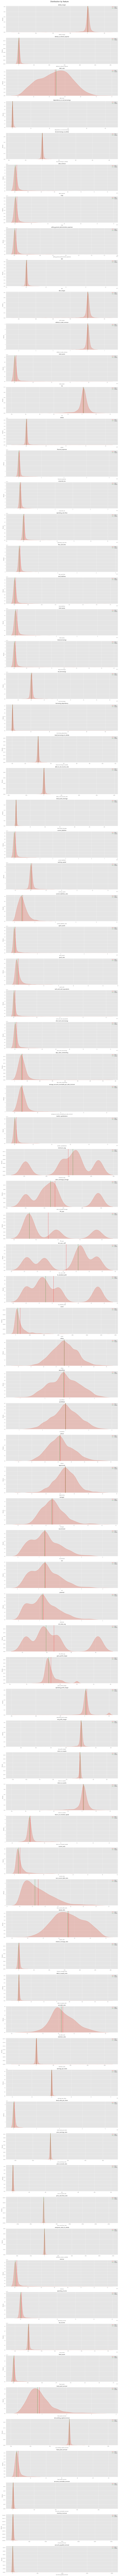

In [79]:
# 칼럼별 데이터 분포 확인
columns_to_plot = data_without_rank.columns[4:]

num_rows = len(columns_to_plot)

fig, axes = plt.subplots(nrows=num_rows, figsize=(15, 4*num_rows))
fig.suptitle('Distribution by feature', y=1, fontsize=16)

for i, column in enumerate(columns_to_plot):
    sns.kdeplot(data_without_rank[column], fill=True, ax=axes[i])

    mean_value = data_without_rank[column].mean()
    median_value = data_without_rank[column].median()

    axes[i].axvline(mean_value, color='r', linestyle='--', label='Mean')
    axes[i].axvline(median_value, color='g', linestyle='--', label='Median')

    axes[i].set_title(column)

    axes[i].legend()

plt.tight_layout()

plt.show()

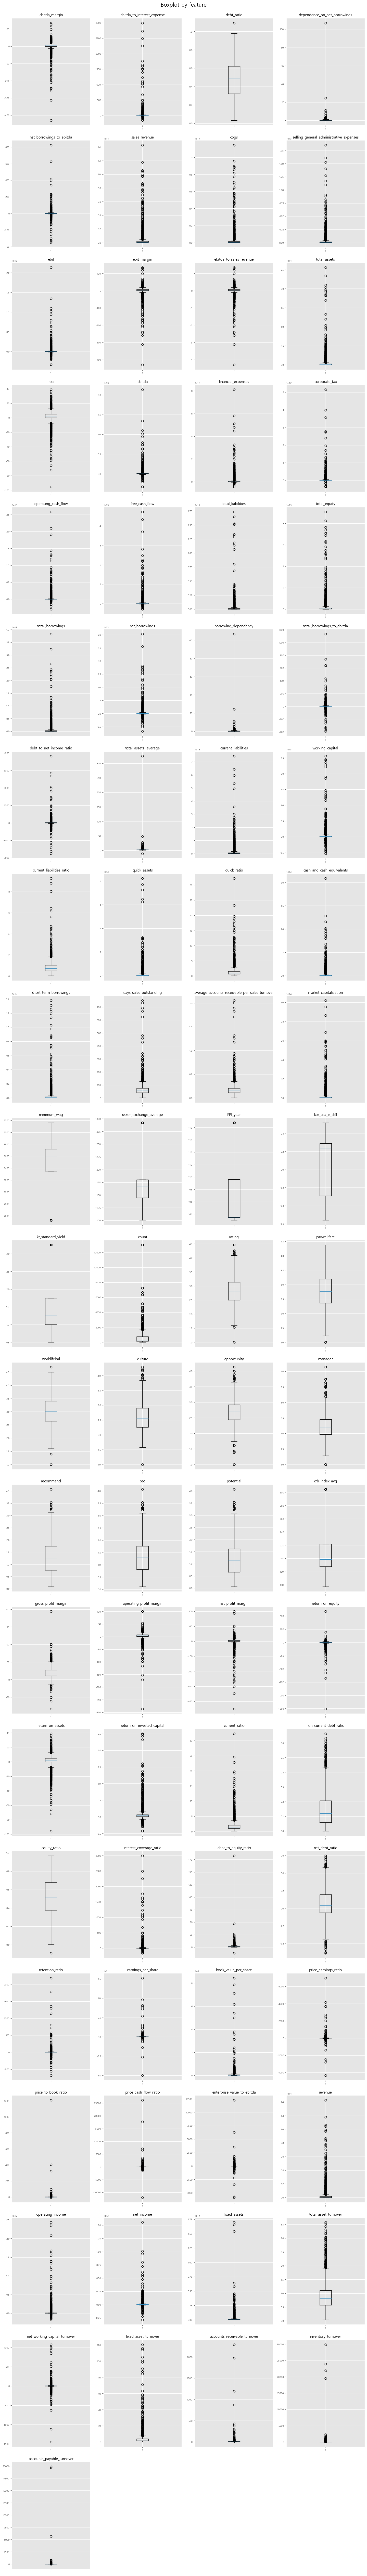

In [80]:
# 칼럼별 박스 플랏 확인
num_columns = 4
num_rows = (len(data_without_rank.columns) - 4) // num_columns + 1

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5*num_rows))

axes = axes.flatten()

for i, column in enumerate(data_without_rank.columns[4:]):
    axes[i].boxplot(data_without_rank[column])
    axes[i].set_title(column)
    
fig.suptitle('Boxplot by feature', y=1, fontsize=16)

for j in range(len(data_without_rank.columns[4:]), num_rows * num_columns):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

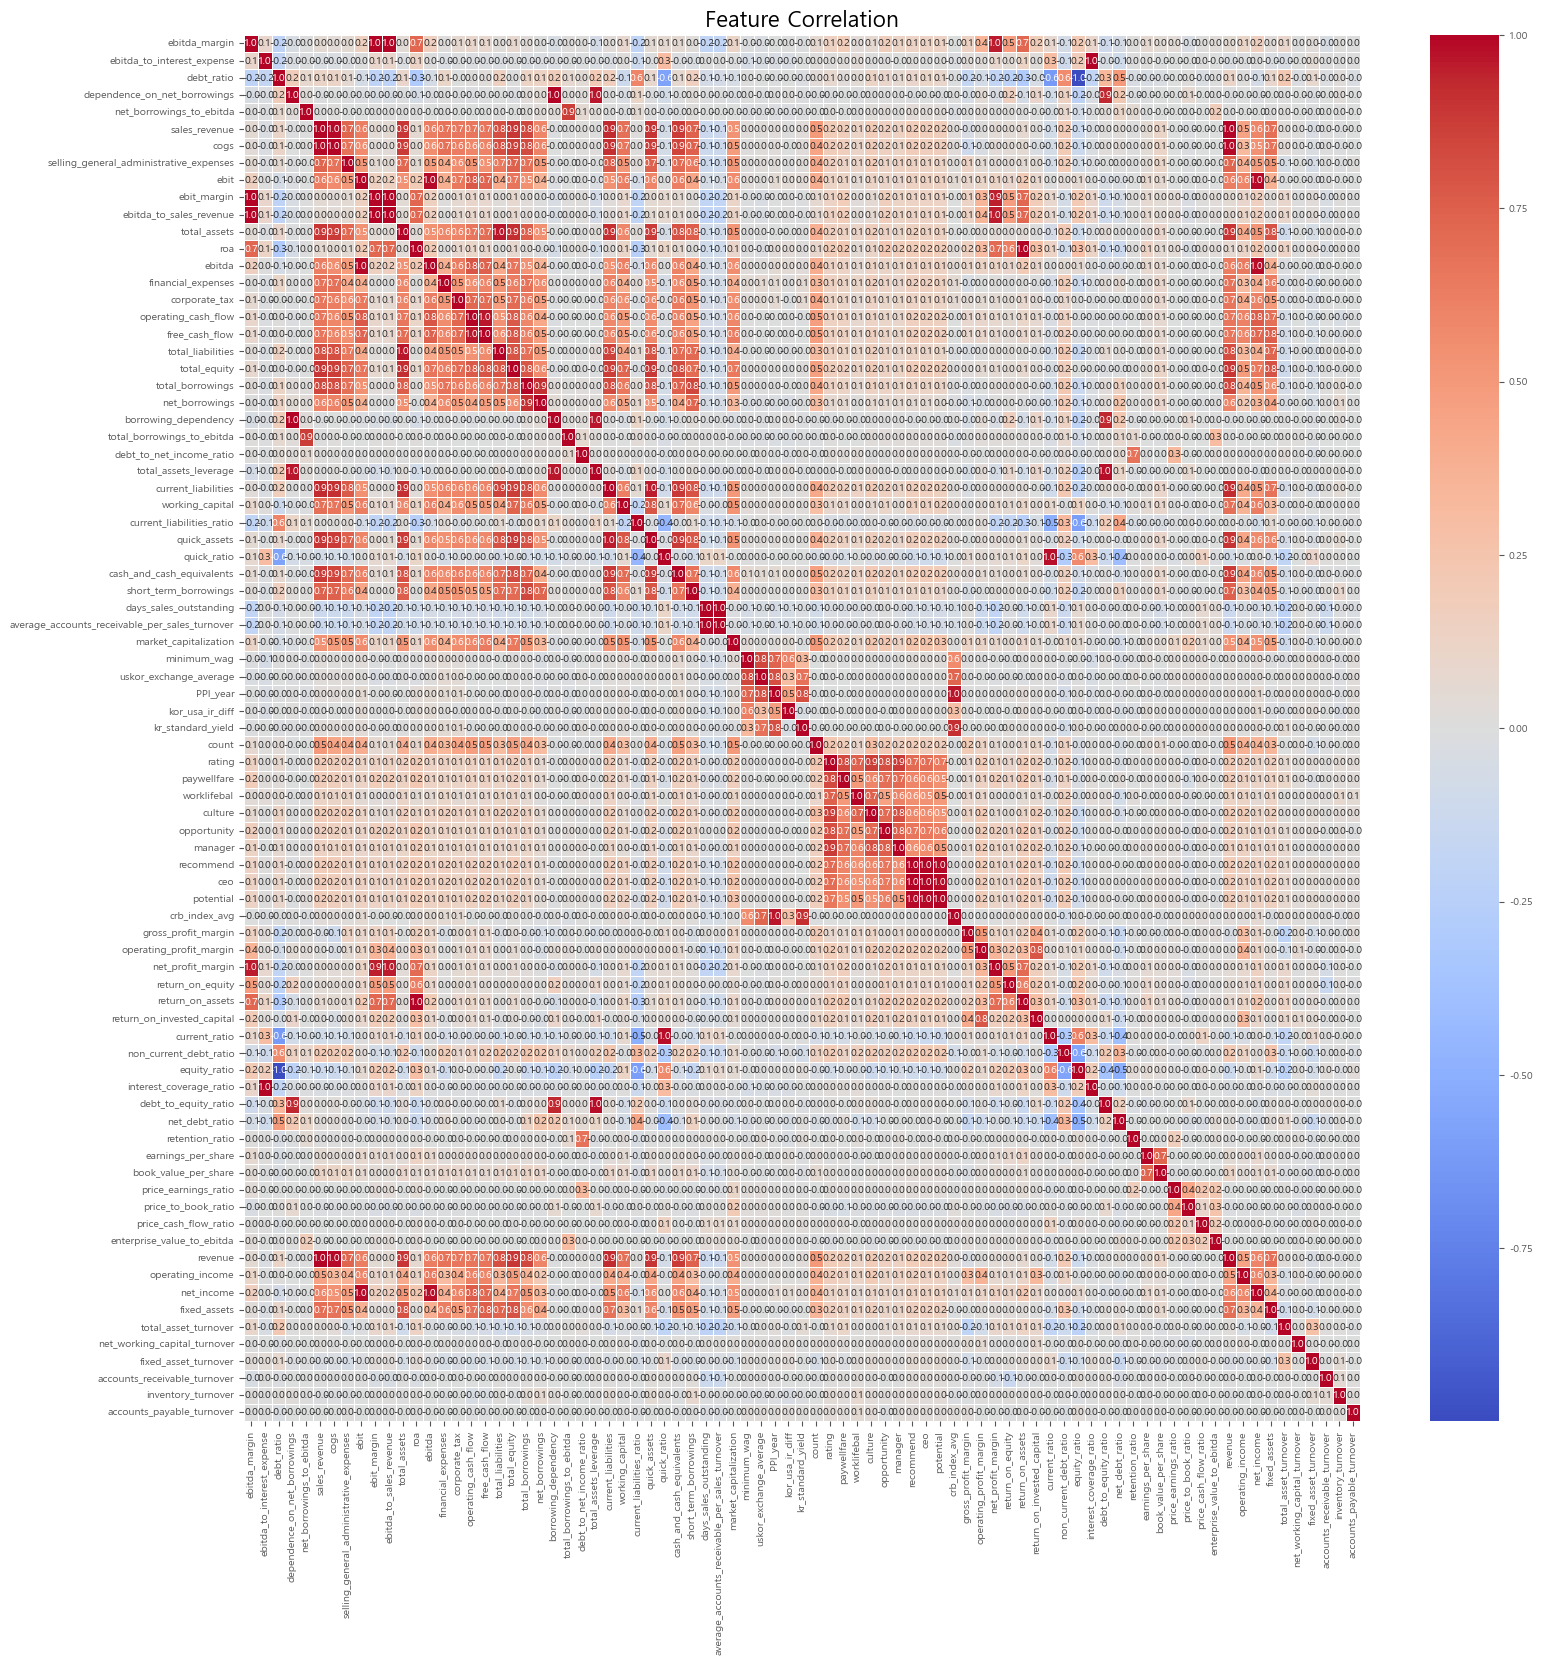

In [107]:
# 상관관계 확인
columns_to_correlate = data_without_rank.columns[4:]
subset_df = data_without_rank[columns_to_correlate]

f, ax = plt.subplots(figsize=(18, 18))
heatmap = sns.heatmap(subset_df.corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax, cmap='coolwarm')
heatmap.set_title('Feature Correlation', fontsize=16)
plt.show()

## 시가총액에 큰 영향을 미치는 변수들은 무엇일까?

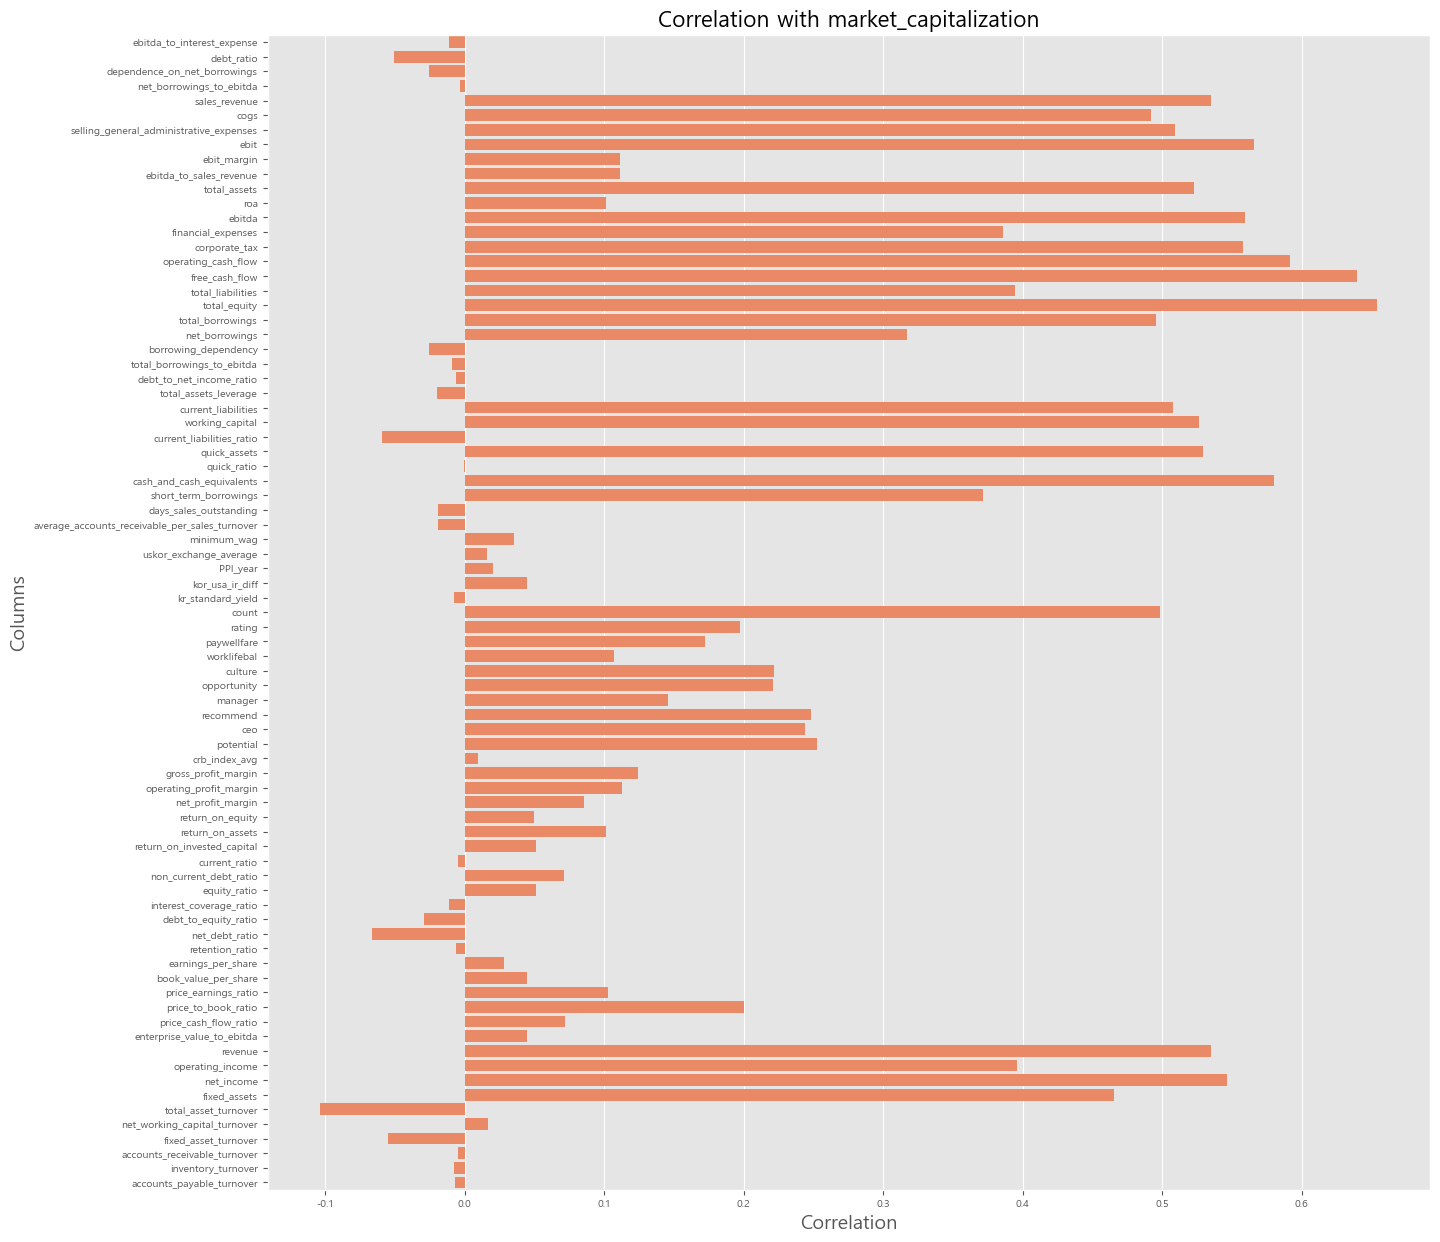

In [82]:
# market_capitalization 칼럼과 다른 칼럼들 간의 상관계수 계산
market_capitalization_correlation = data_without_rank.iloc[:, 5:].corrwith(data_without_rank['market_capitalization']).drop('market_capitalization')

# 상관계수를 시각화하여 가장 영향을 많이 주는 칼럼 파악
plt.figure(figsize=(15, 15))
sns.barplot(x=market_capitalization_correlation.values, y=market_capitalization_correlation.index, orient='h', color='Coral')
plt.title('Correlation with market_capitalization', fontsize=16)
plt.xlabel('Correlation', fontsize=14)
plt.ylabel('Columns', fontsize=14)
plt.show()

In [93]:
# 상관관계가 높은 상위 5개의 칼럼 추출
top_5_columns = market_capitalization_correlation.nlargest(5)
bot_5_columns = market_capitalization_correlation.nsmallest(5)

# 결과 출력
print("시가총액에 긍정적인 영향을 미치는 Top 5:")
for column, correlation in top_5_columns.items():
    print(f"{column} {np.round(correlation, 2)}")
    
print('')
print("시가총액에 부정적인 영향을 미치는 Top 5:")
for column, correlation in bot_5_columns.items():
    print(f"{column} {np.round(correlation, 2)}")

시가총액에 긍정적인 영향을 미치는 Top 5:
total_equity 0.65
free_cash_flow 0.64
operating_cash_flow 0.59
cash_and_cash_equivalents 0.58
ebit 0.57

시가총액에 부정적인 영향을 미치는 Top 5:
total_asset_turnover -0.1
net_debt_ratio -0.07
current_liabilities_ratio -0.06
fixed_asset_turnover -0.06
debt_ratio -0.05


## 매출액에 큰 영향을 미치는 변수는 무엇일까?

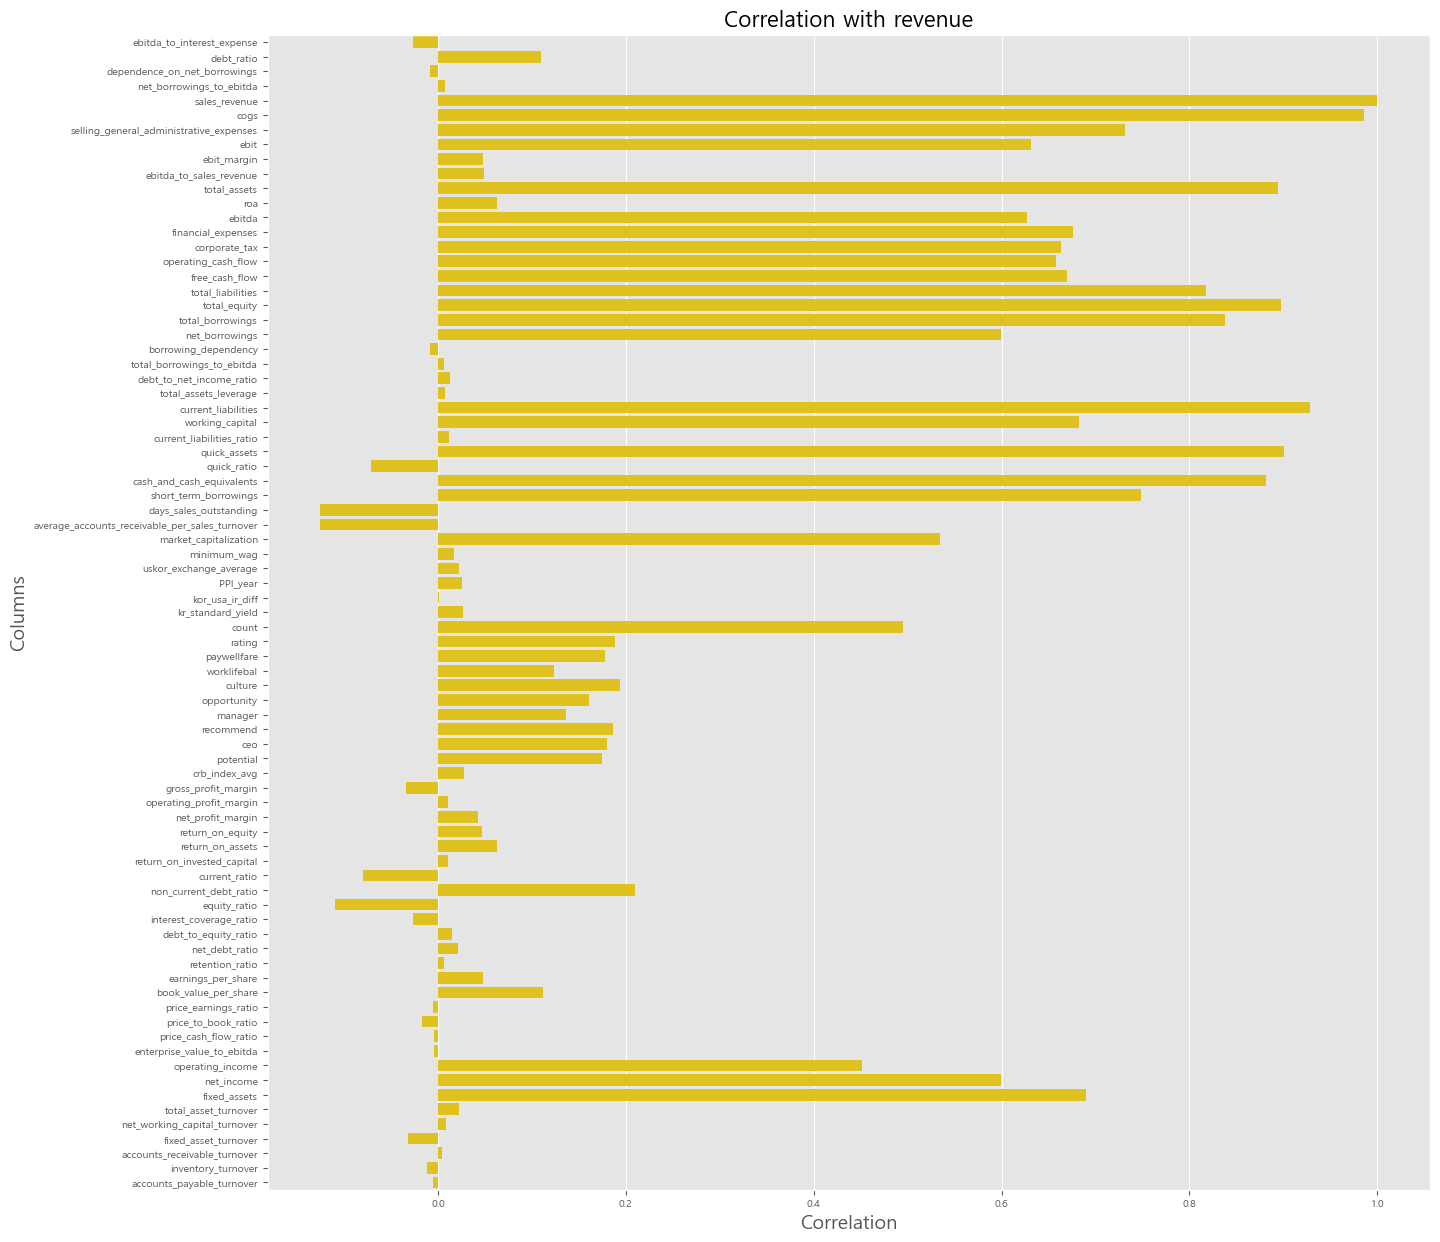

In [116]:
# revenue 칼럼과 다른 칼럼들 간의 상관계수 계산
revenue_correlation = data_without_rank.iloc[:, 5:].corrwith(data_without_rank['revenue']).drop('revenue')

# 상관계수를 시각화하여 가장 영향을 많이 주는 칼럼 파악
plt.figure(figsize=(15, 15))
sns.barplot(x=revenue_correlation.values, y=revenue_correlation.index, orient='h', color='Gold')
plt.title('Correlation with revenue', fontsize=16)
plt.xlabel('Correlation', fontsize=14)
plt.ylabel('Columns', fontsize=14)
plt.show()

In [112]:
# 상관관계가 높은 상위 5개의 칼럼 추출
top_5_columns = revenue_correlation.nlargest(5)
bot_5_columns = revenue_correlation.nsmallest(5)

# 결과 출력
print("매출액에 긍정적인 영향을 미치는 Top 5:")
for column, correlation in top_5_columns.items():
    print(f"{column} {np.round(correlation, 2)}")
    
print('')
print("매출액에 부정적인 영향을 미치는 Top 5:")
for column, correlation in bot_5_columns.items():
    print(f"{column} {np.round(correlation, 2)}")

매출액에 긍정적인 영향을 미치는 Top 5:
sales_revenue 1.0
cogs 0.99
current_liabilities 0.93
quick_assets 0.9
total_equity 0.9

매출액에 부정적인 영향을 미치는 Top 5:
average_accounts_receivable_per_sales_turnover -0.13
days_sales_outstanding -0.13
equity_ratio -0.11
current_ratio -0.08
quick_ratio -0.07


## data_with_rank
- 신용지표가 존재하는 840개의 기업을 대상으로 EDA

In [17]:
print(data_with_rank.info())
print(data_with_rank.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 840 entries, 1 to 3094
Data columns (total 86 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   corp                                            840 non-null    object 
 1   stock_code                                      840 non-null    object 
 2   sector                                          840 non-null    object 
 3   year                                            840 non-null    object 
 4   ebitda_margin                                   840 non-null    float64
 5   ebitda_to_interest_expense                      840 non-null    float64
 6   debt_ratio                                      840 non-null    float64
 7   dependence_on_net_borrowings                    840 non-null    float64
 8   net_borrowings_to_ebitda                        840 non-null    float64
 9   sales_revenue                                  

rank 값 수치화

In [18]:
data_with_rank['rank'].unique()

array(['BBB', 'AA-', 'AA', 'A', 'A-', 'A+', 'JB', 'AA+', 'AAA'],
      dtype=object)

In [19]:
# rank 열 값 처리
rank_mapping = {
    None: None,
    'JB': 1,
    'BBB':2,
    'A-': 3,
    'A': 4,
    'A+': 5,
    'AA-': 6,
    'AA': 7,
    'AA+': 8,
    'AAA': 9
}
data_with_rank['rank'] = data_with_rank['rank'].map(rank_mapping)

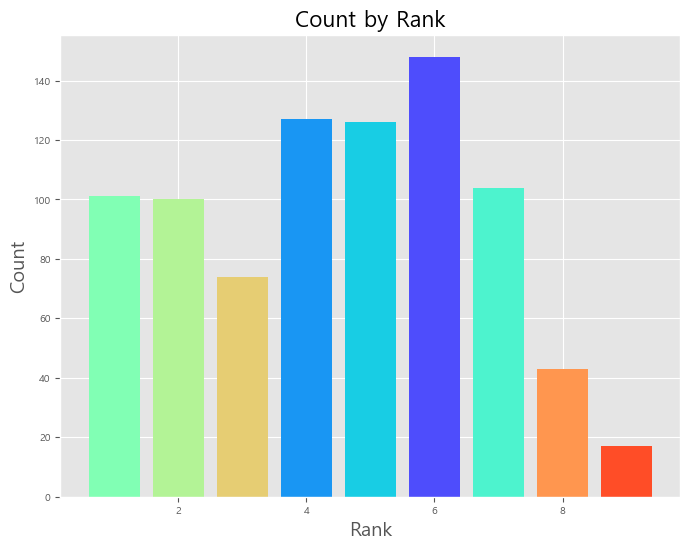

In [20]:
# rank별 카운트 집계
# 'rank' 열별로 개수를 계산
rank_counts = data_with_rank['rank'].value_counts()

# 막대 그래프의 색상을 무지개색으로 지정
colors = sns.color_palette('rainbow', len(rank_counts))

# 바 그래프로 시각화 (색상 변경)
plt.figure(figsize=(8, 6))
plt.bar(rank_counts.index, rank_counts.values, color=colors)
plt.title('Count by Rank', fontsize=16)
plt.xlabel('Rank', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

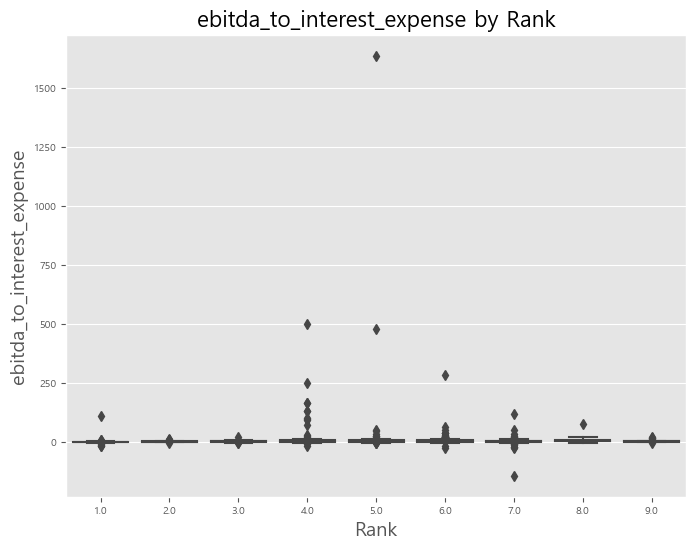

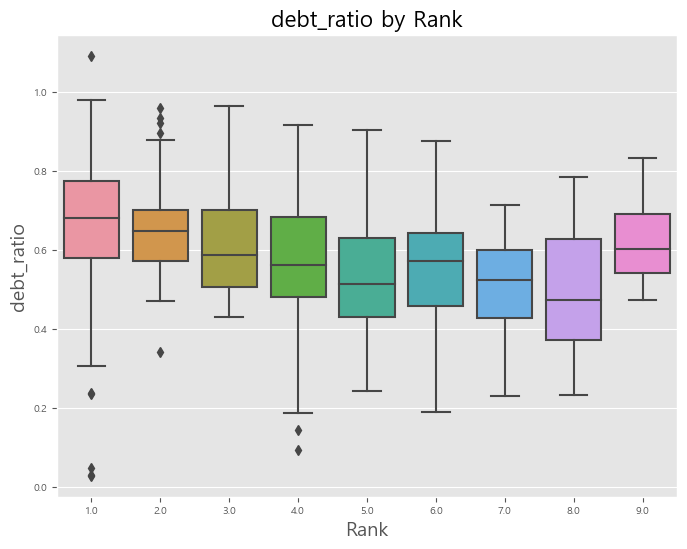

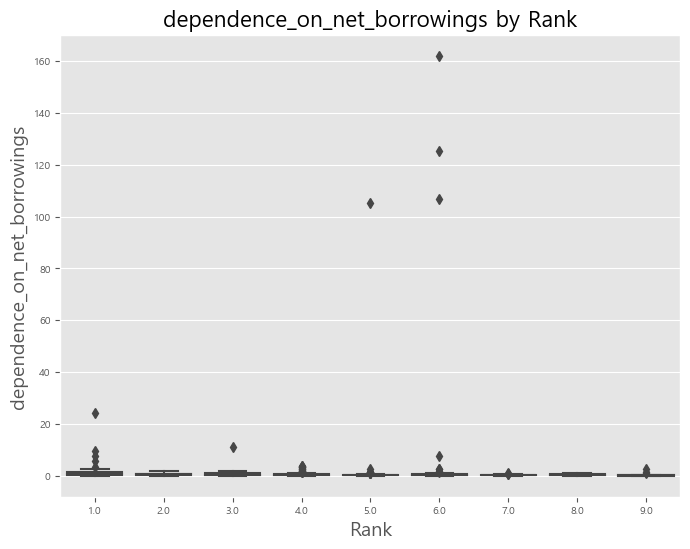

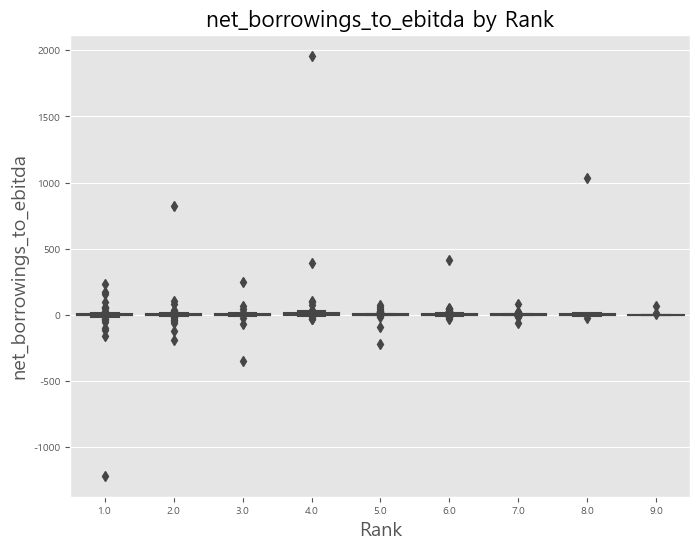

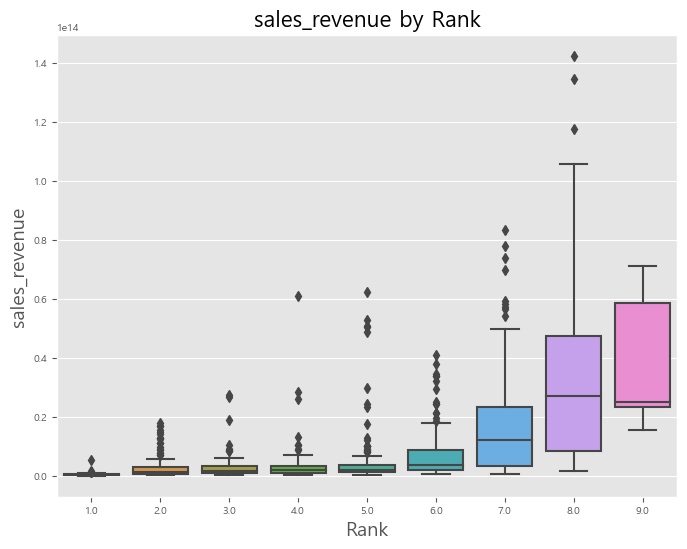

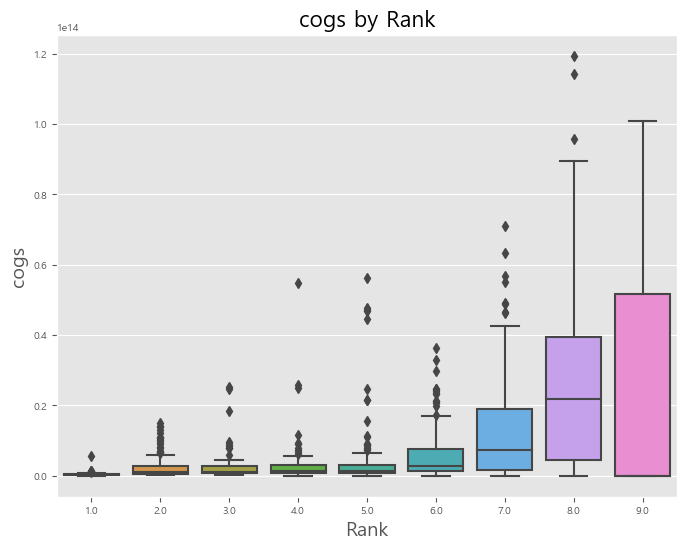

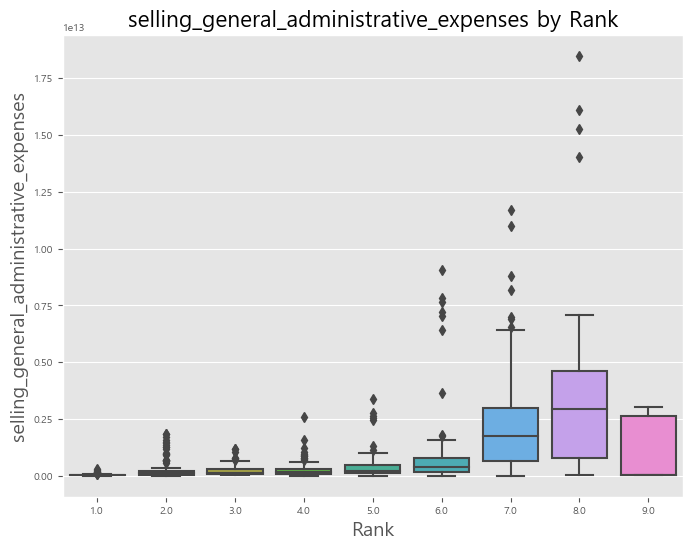

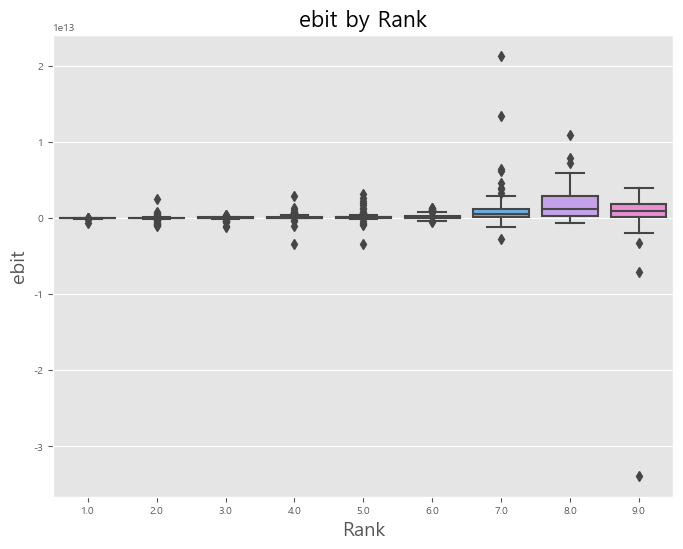

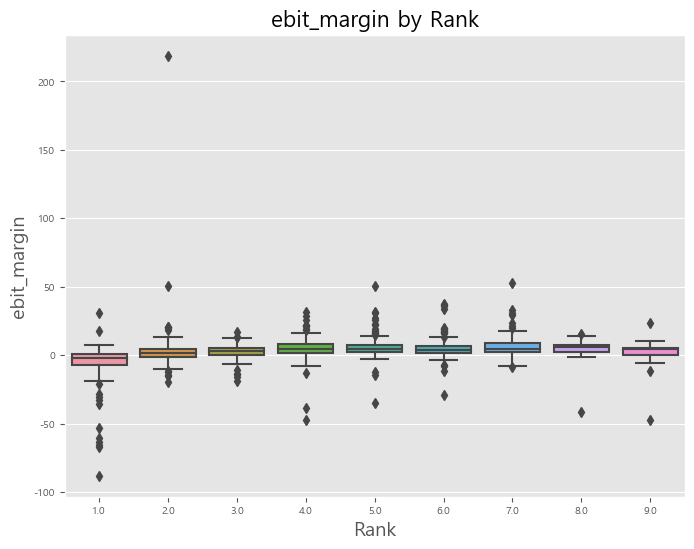

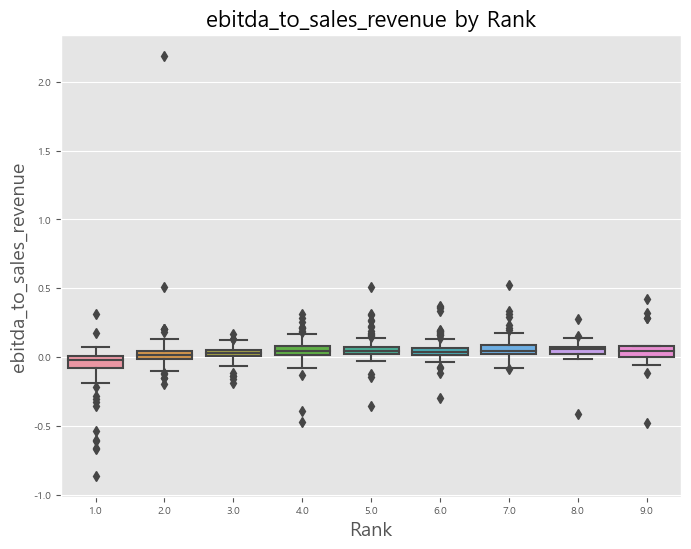

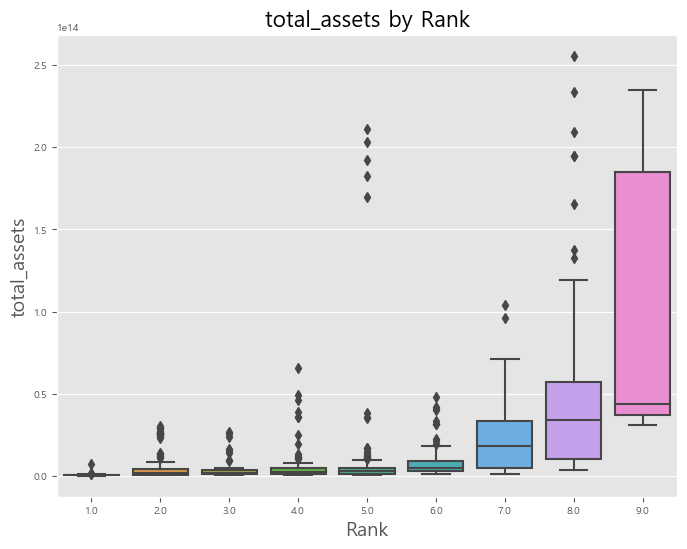

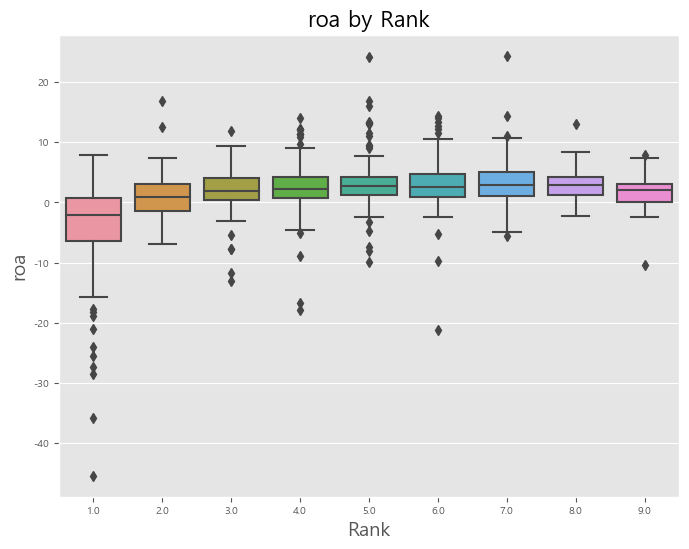

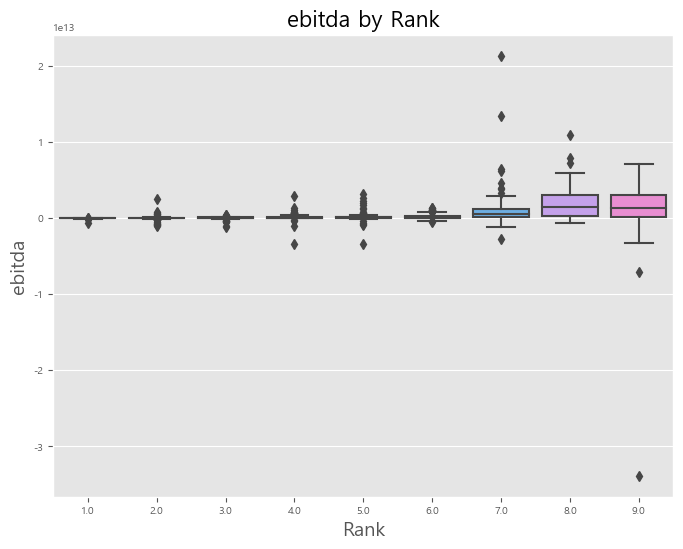

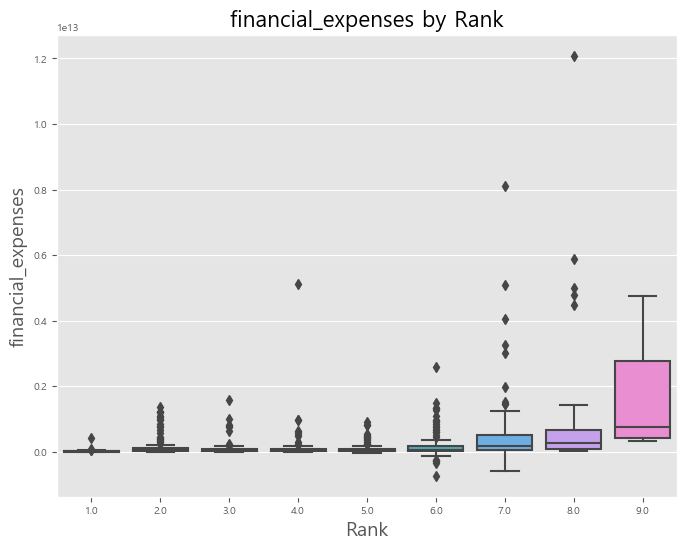

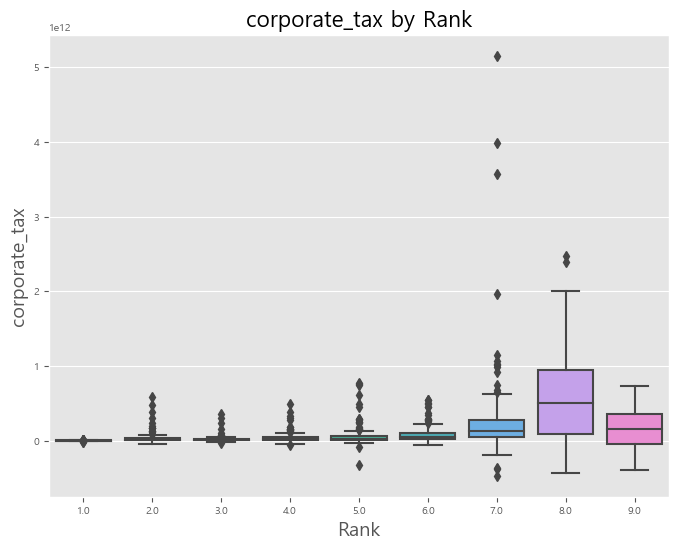

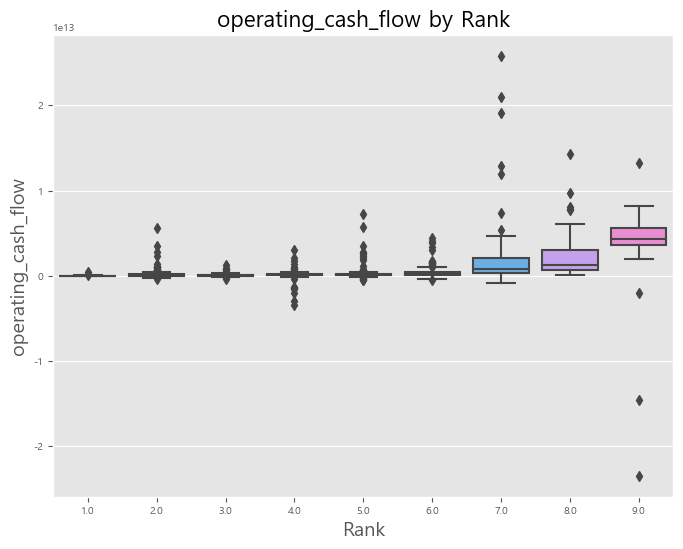

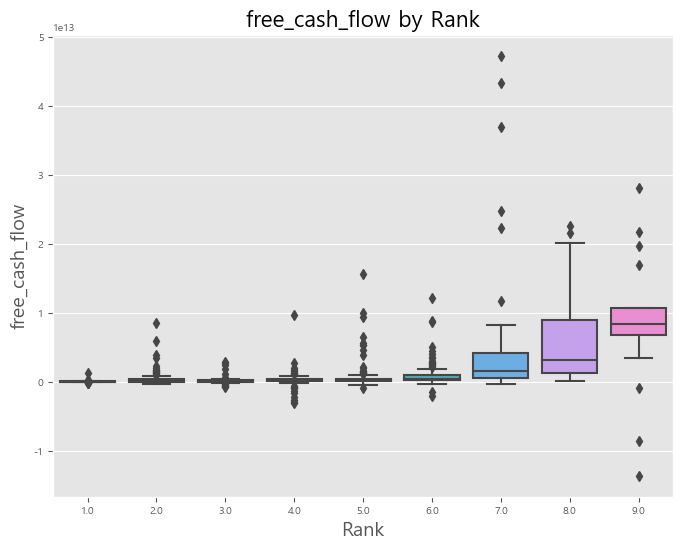

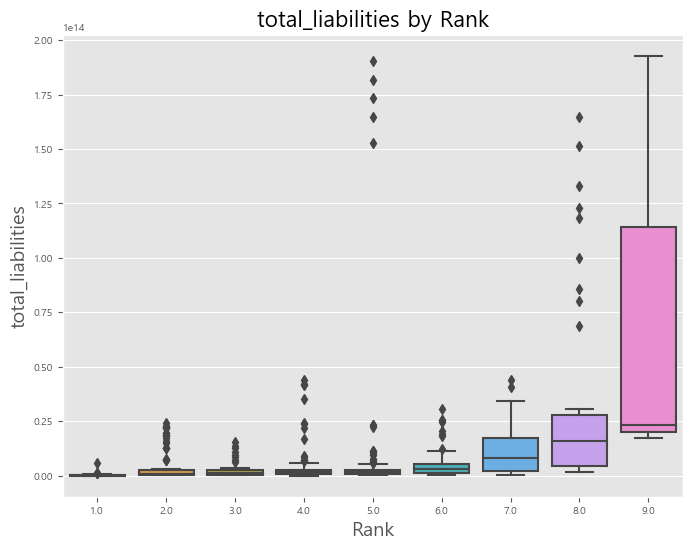

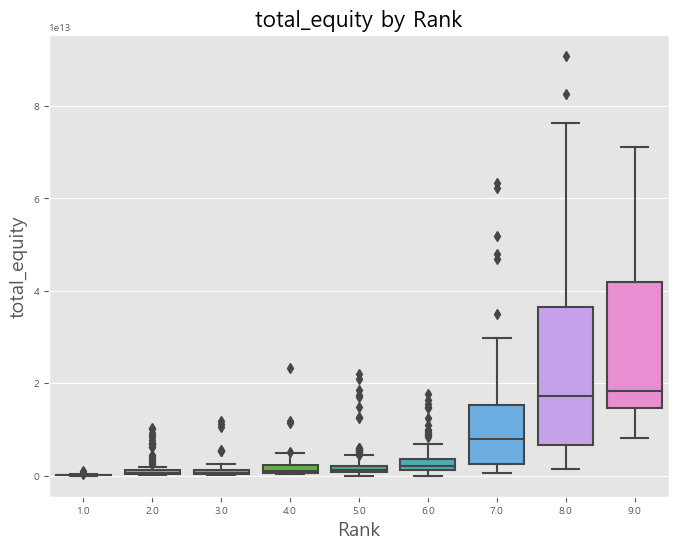

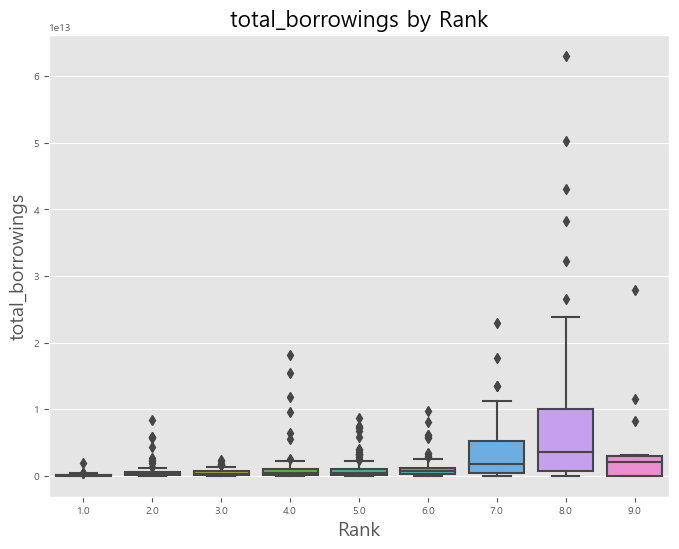

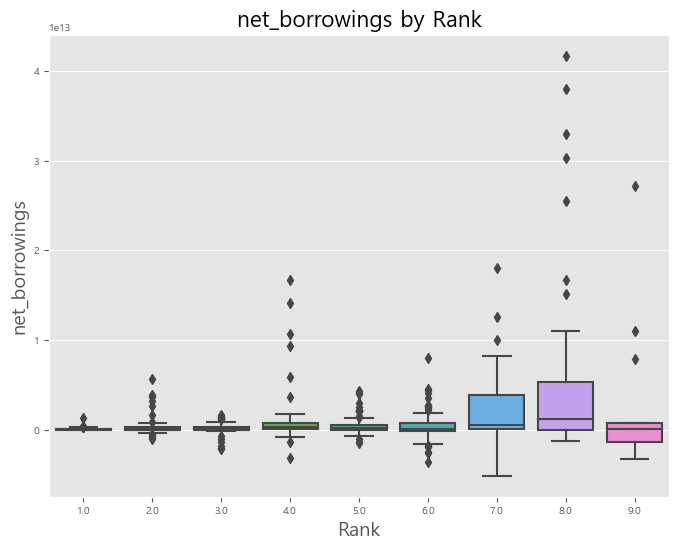

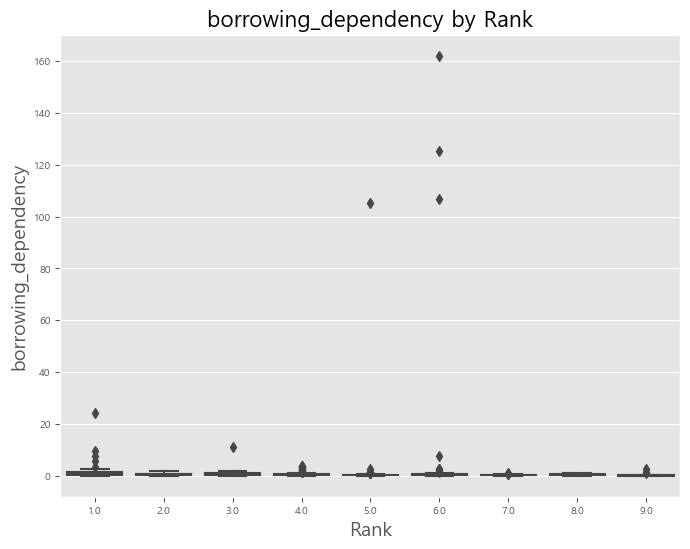

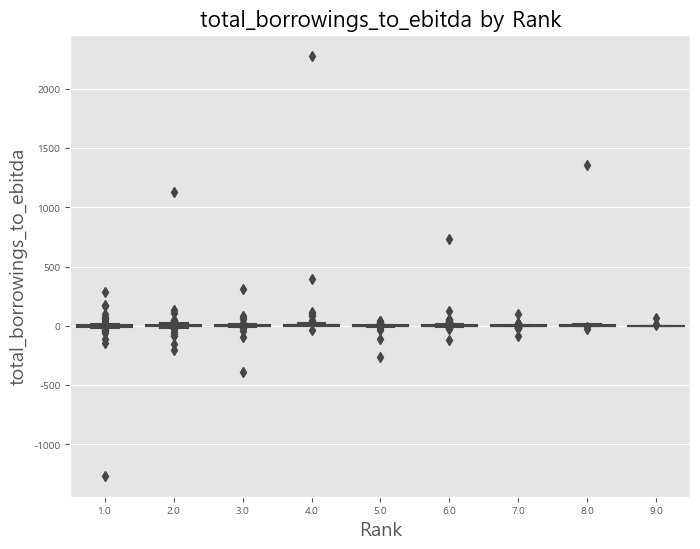

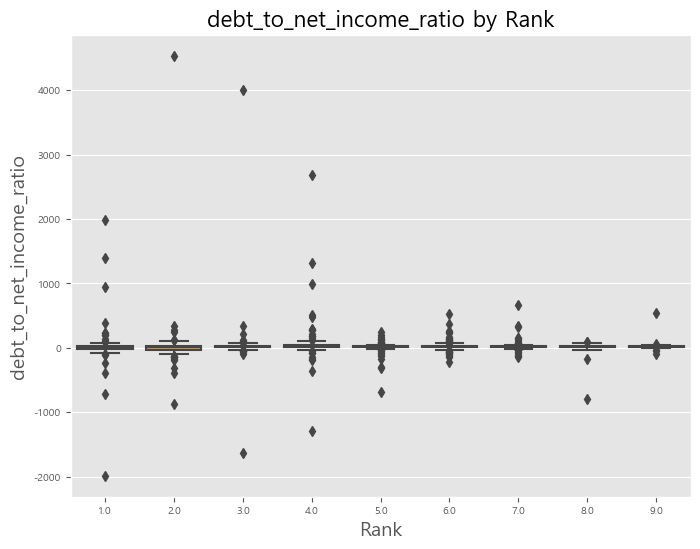

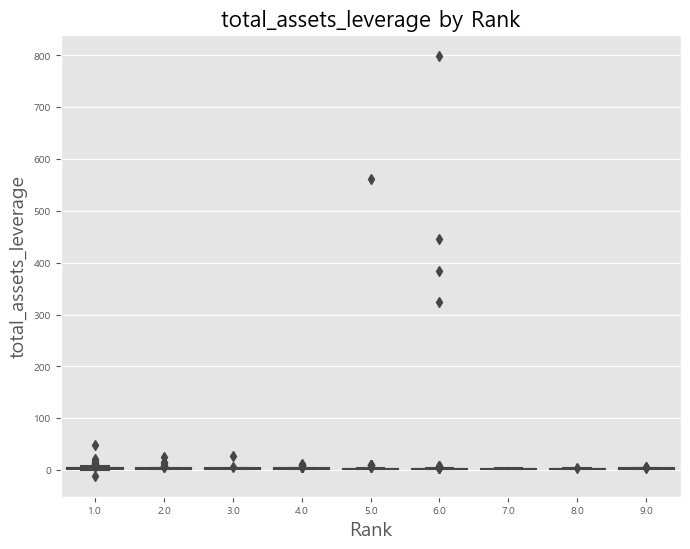

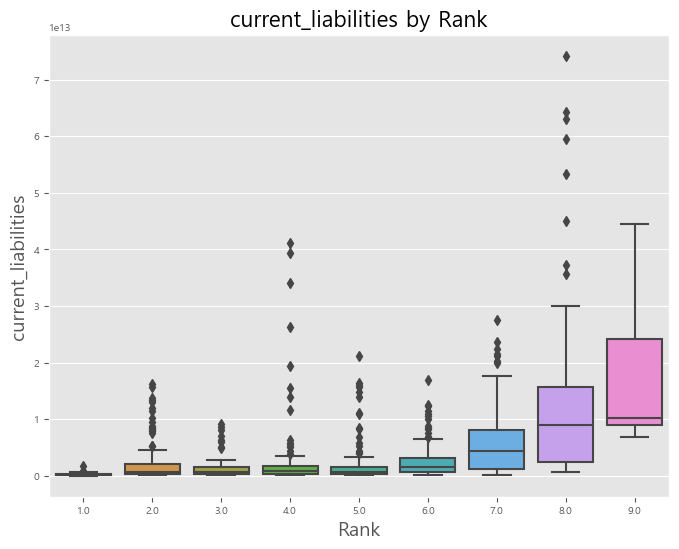

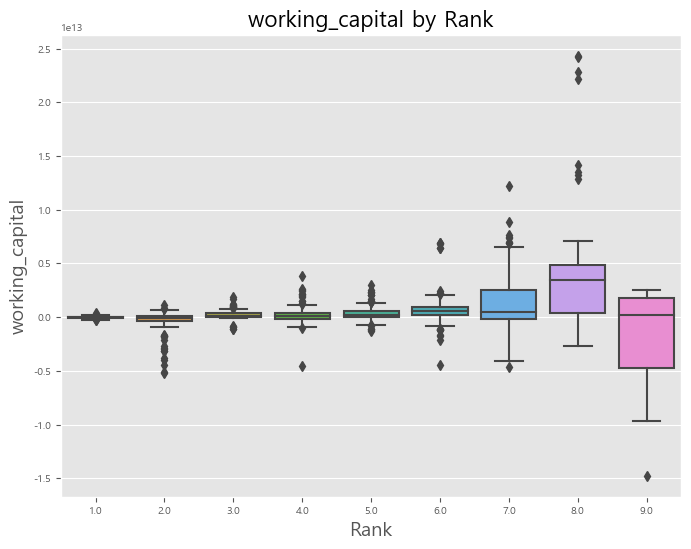

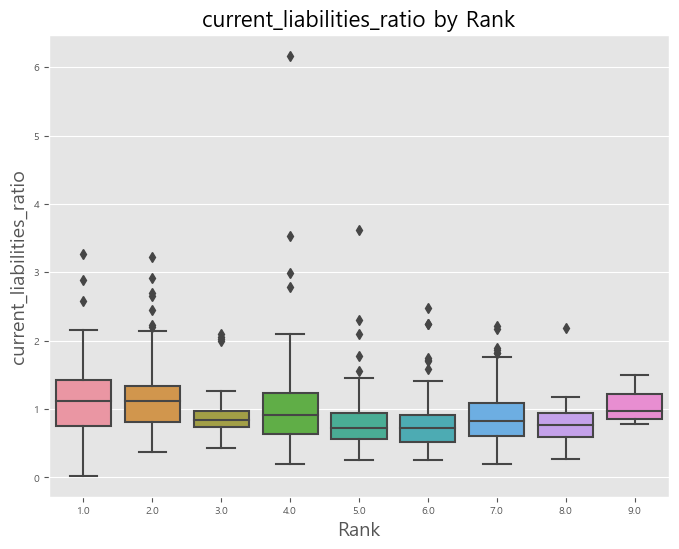

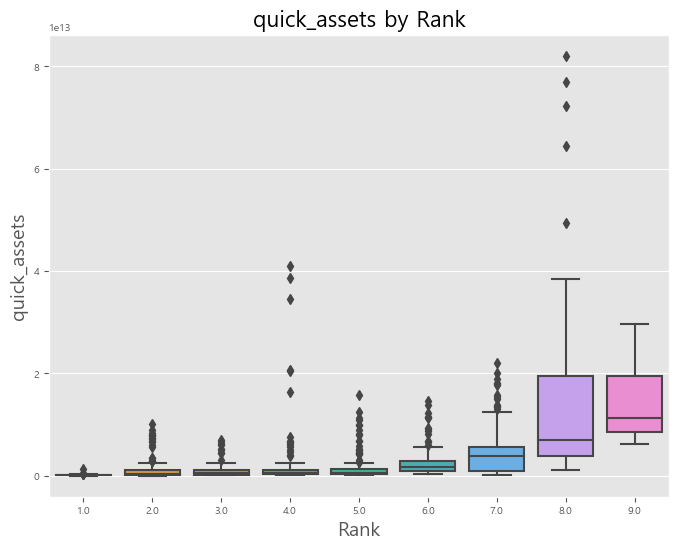

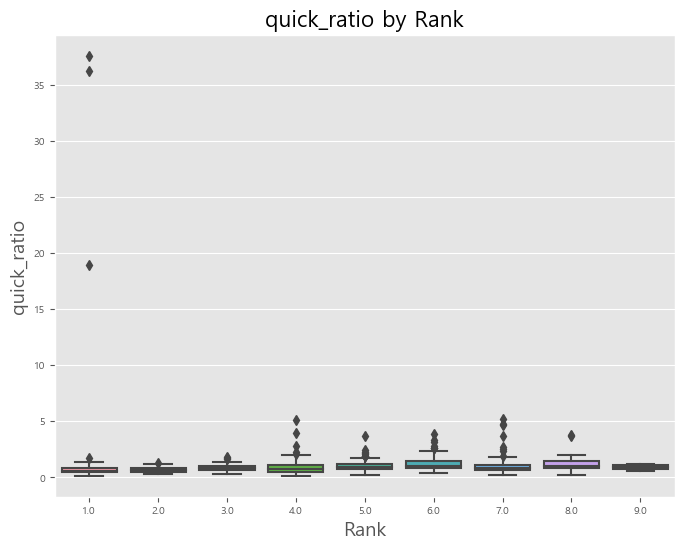

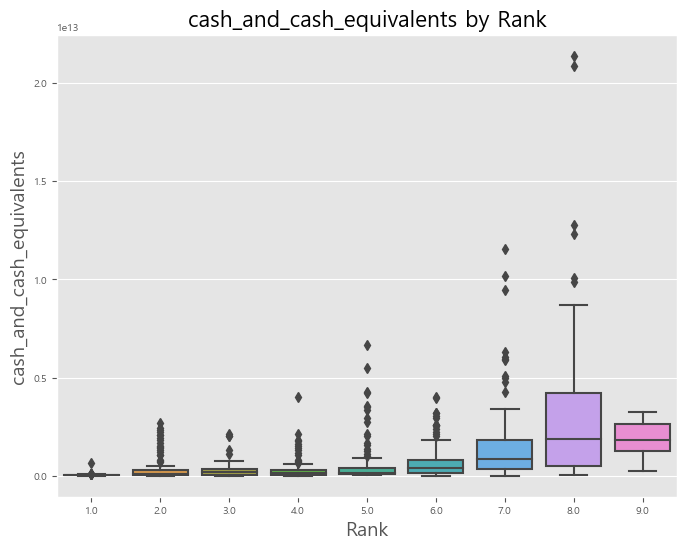

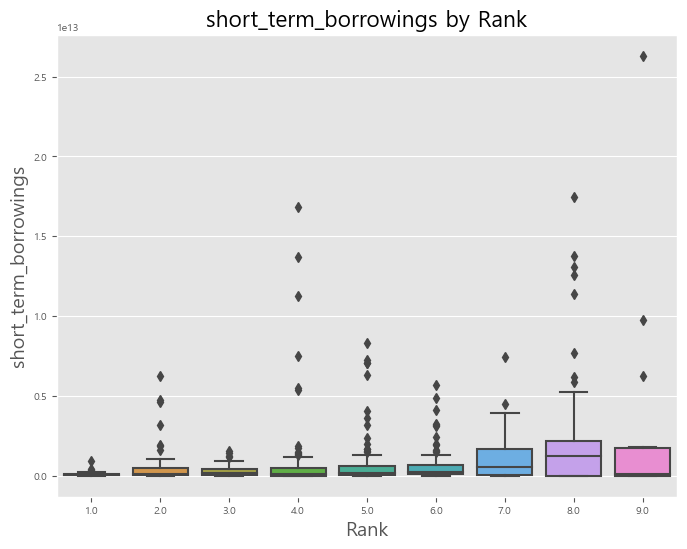

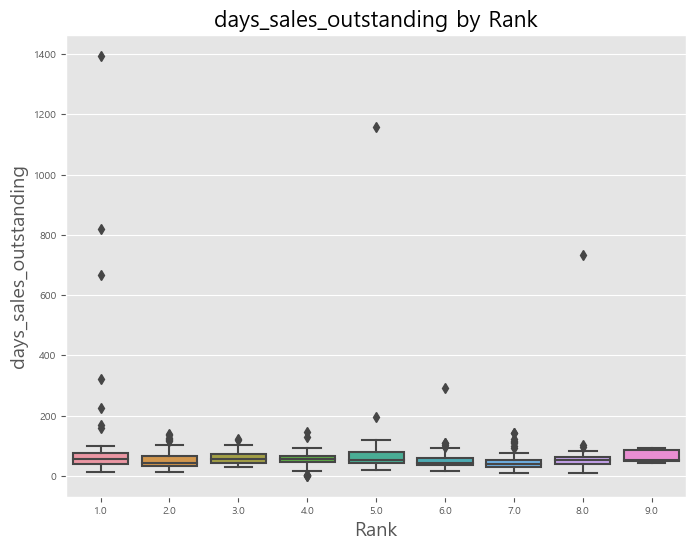

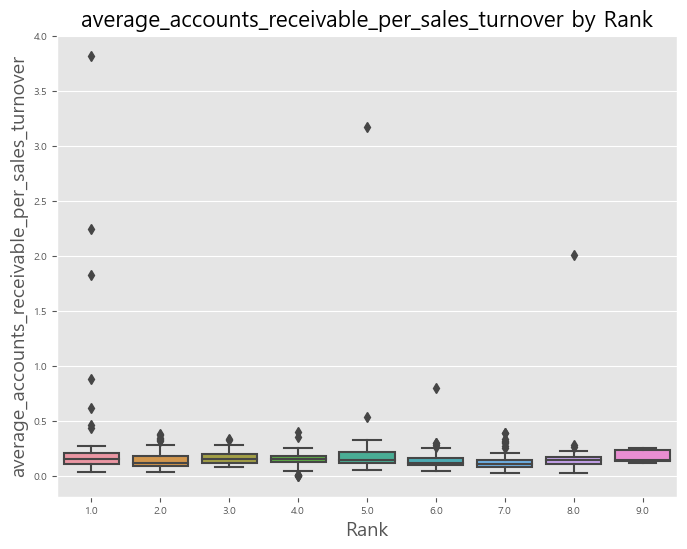

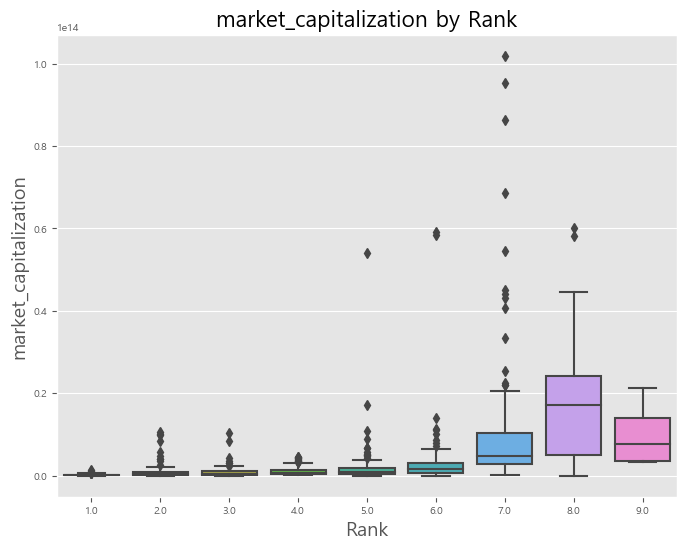

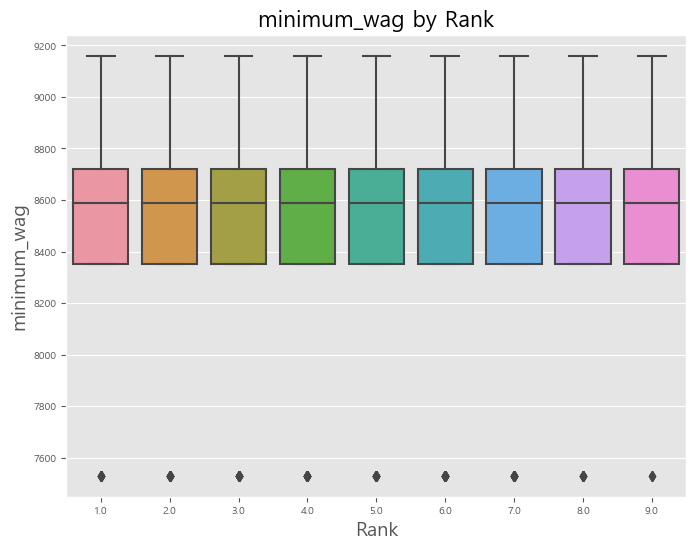

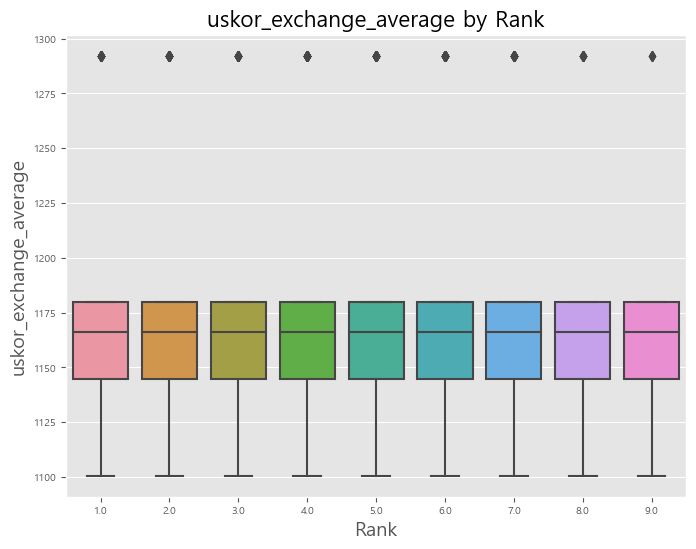

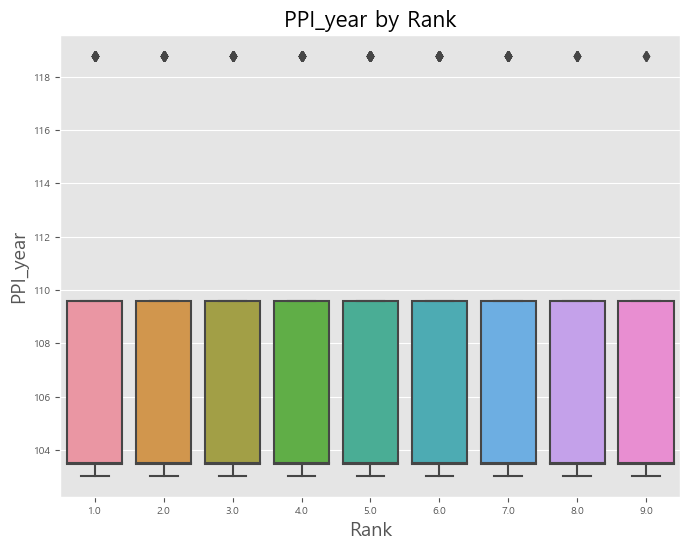

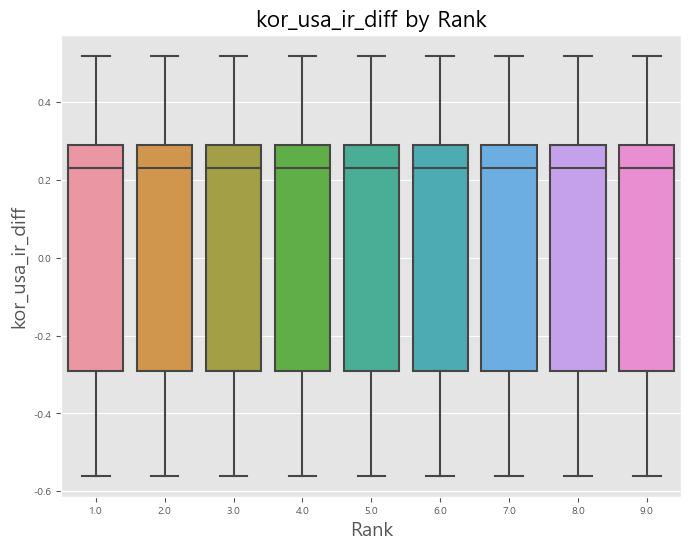

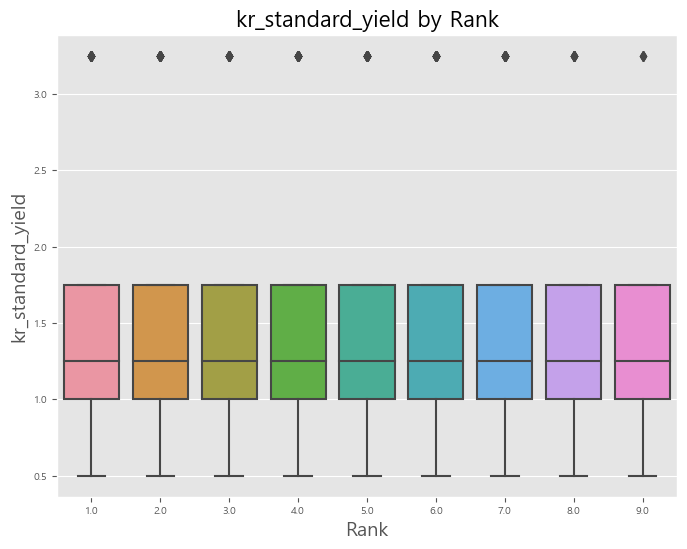

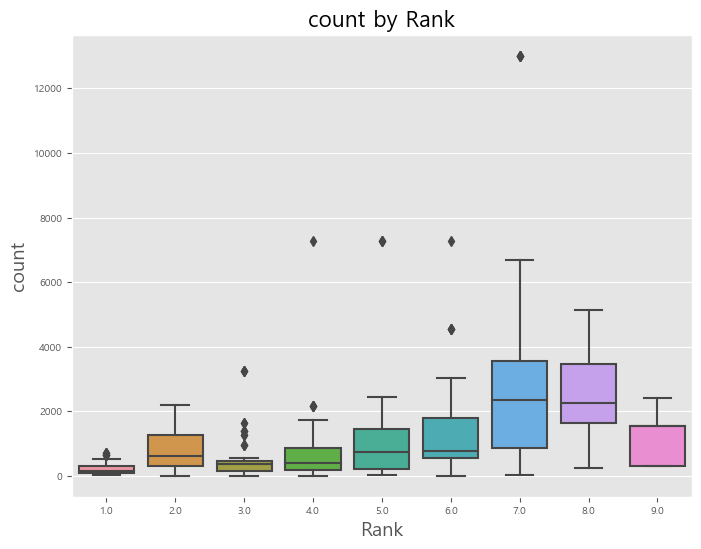

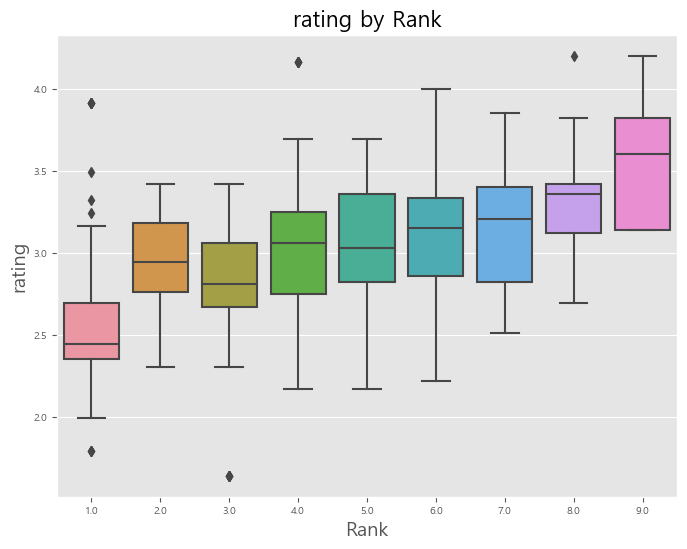

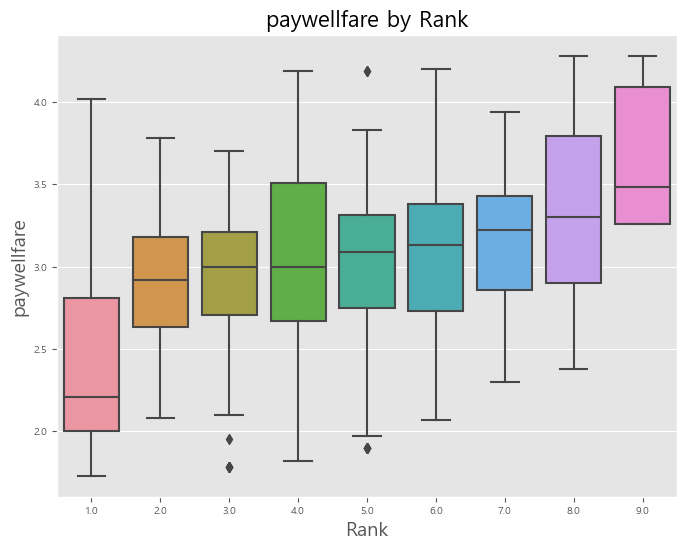

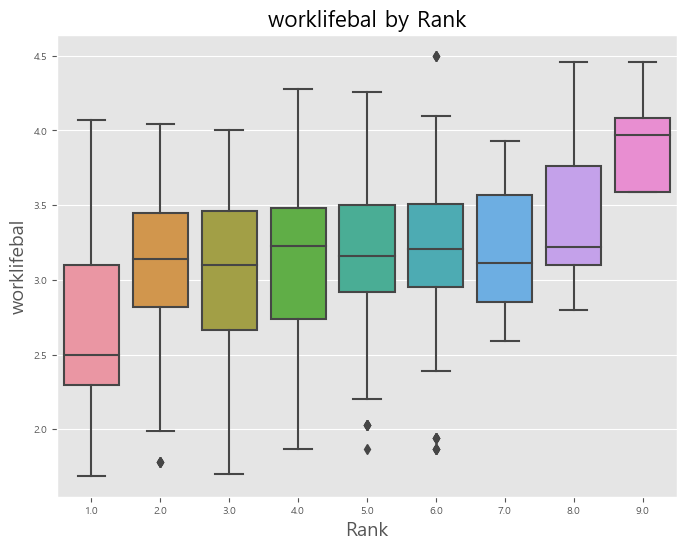

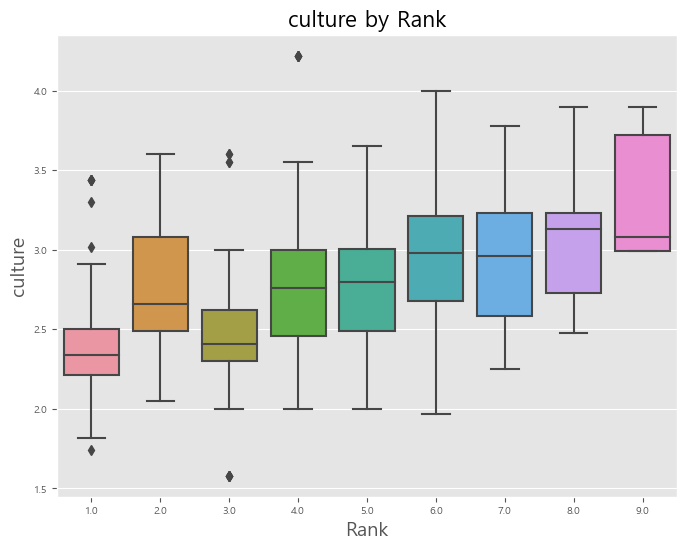

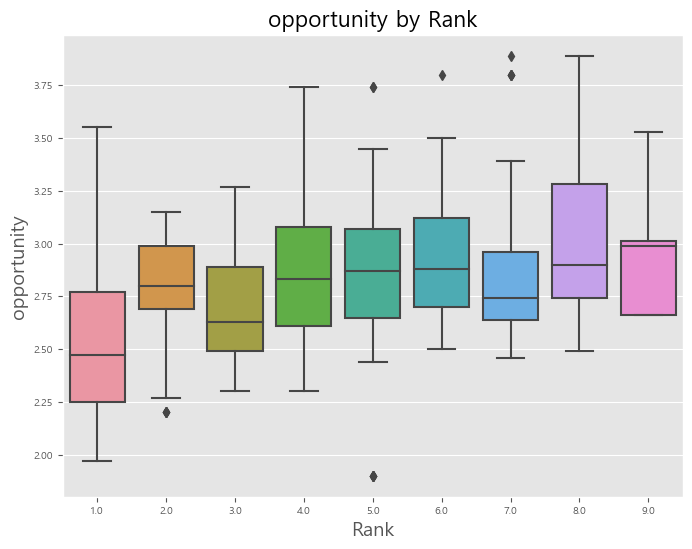

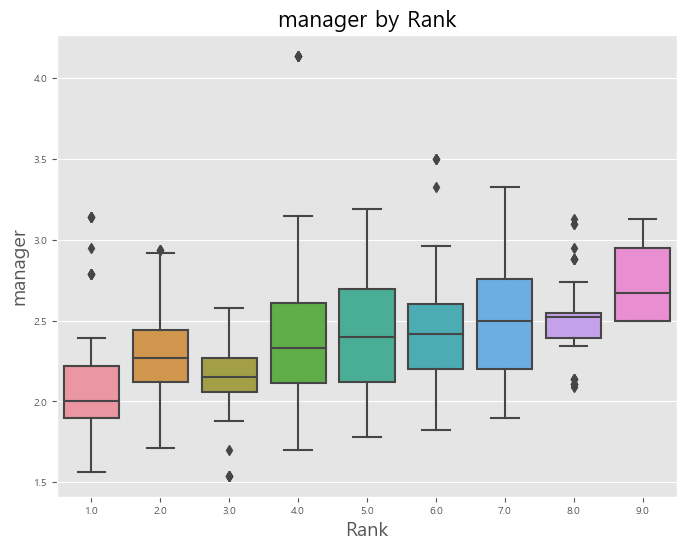

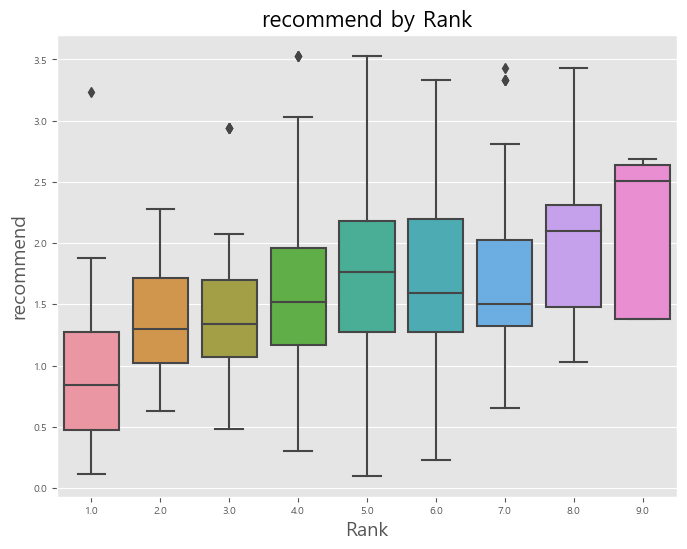

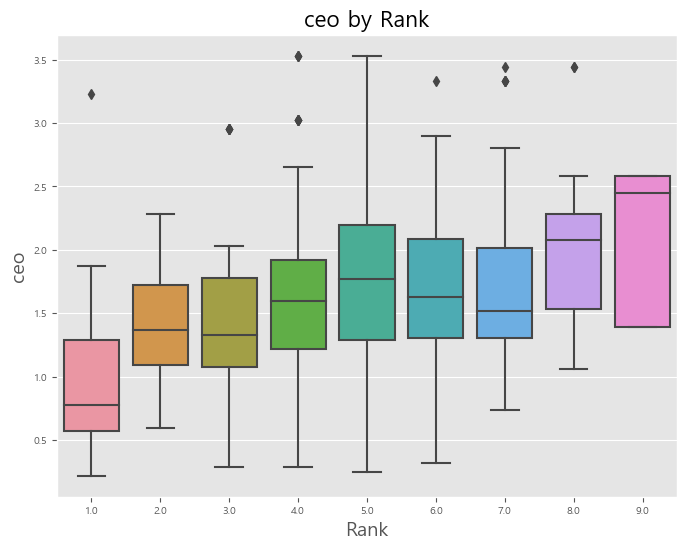

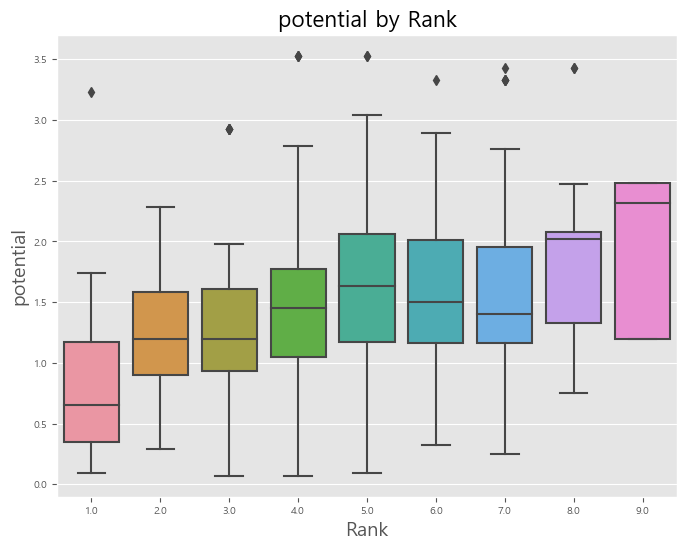

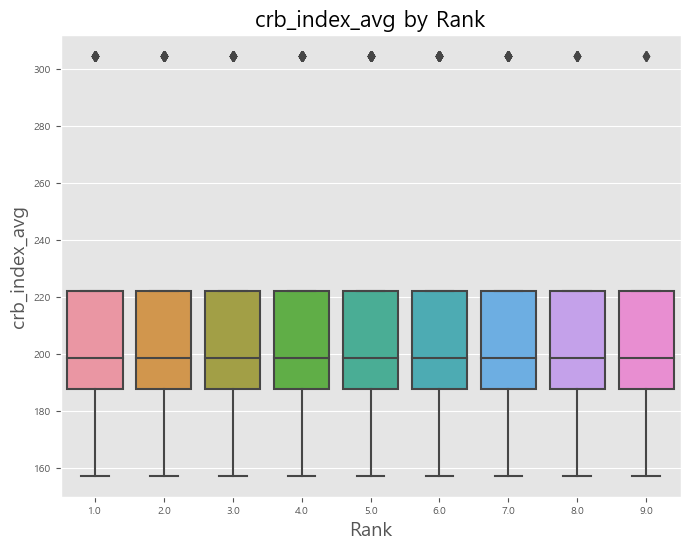

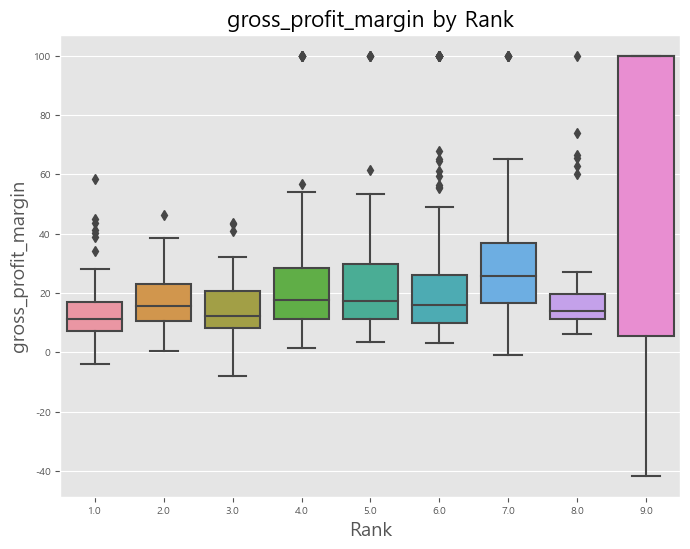

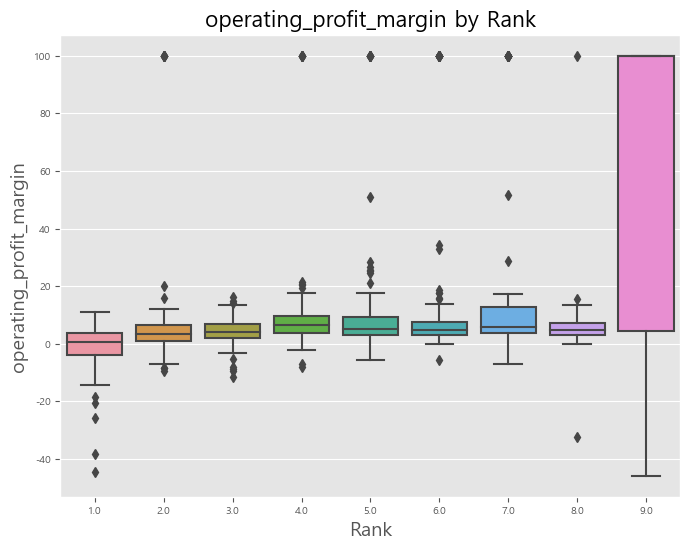

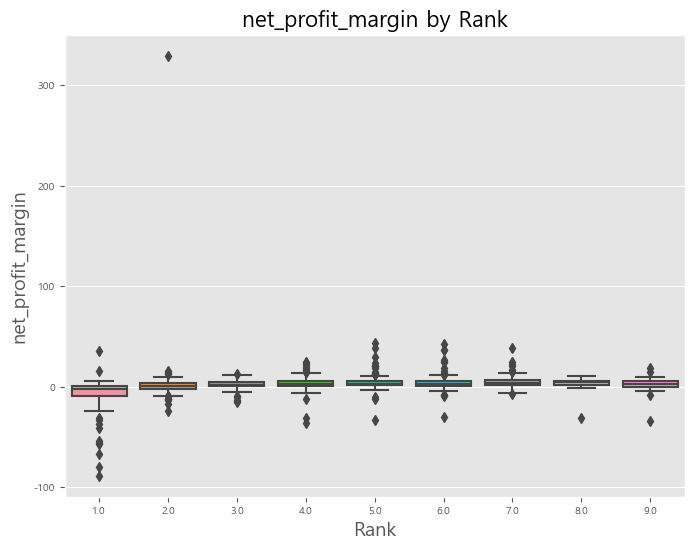

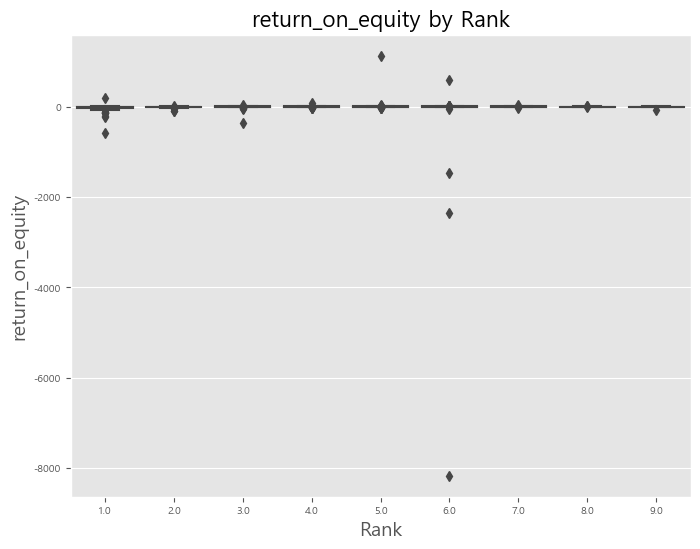

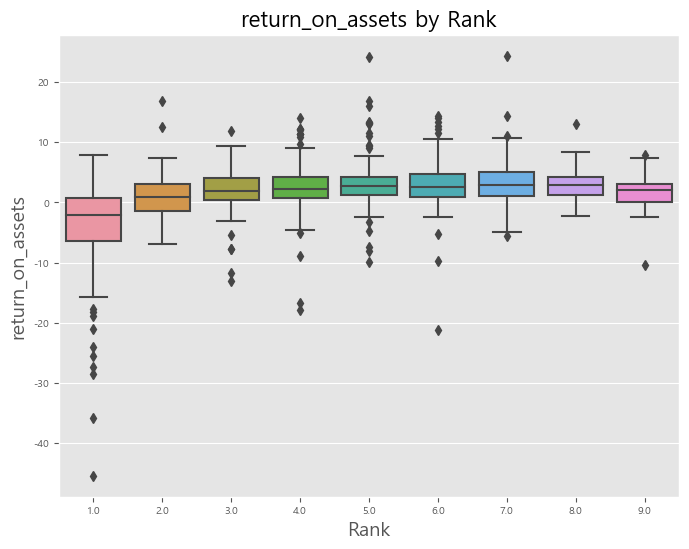

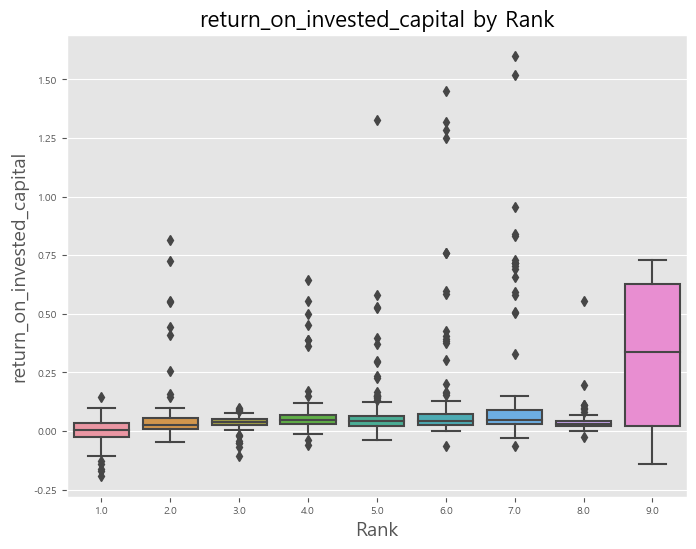

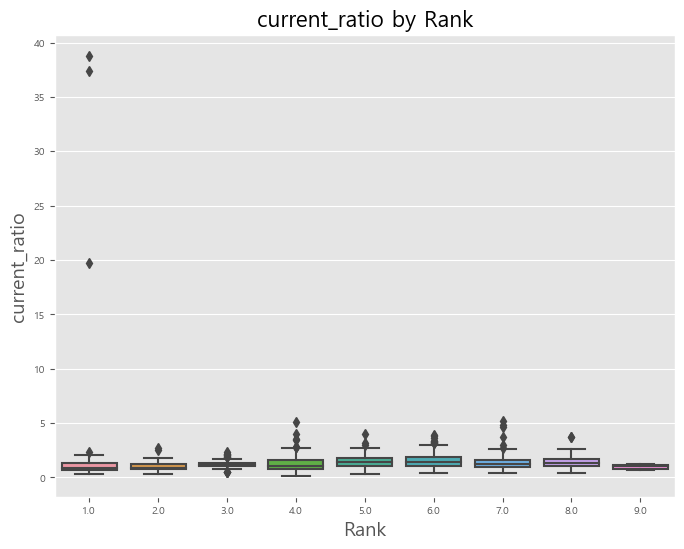

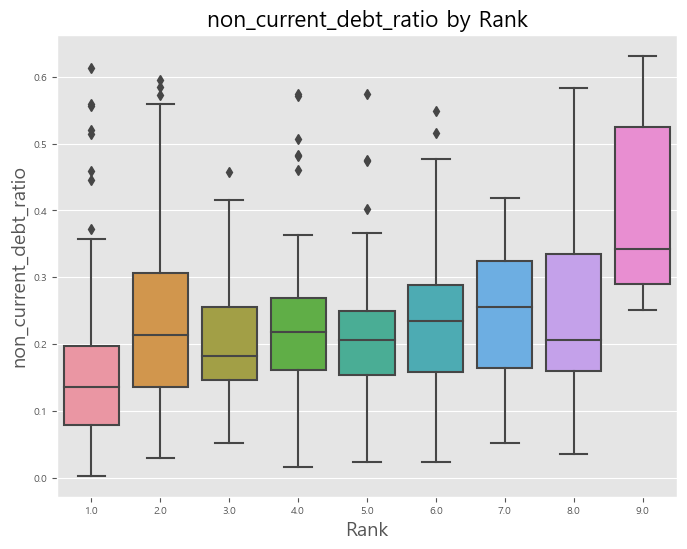

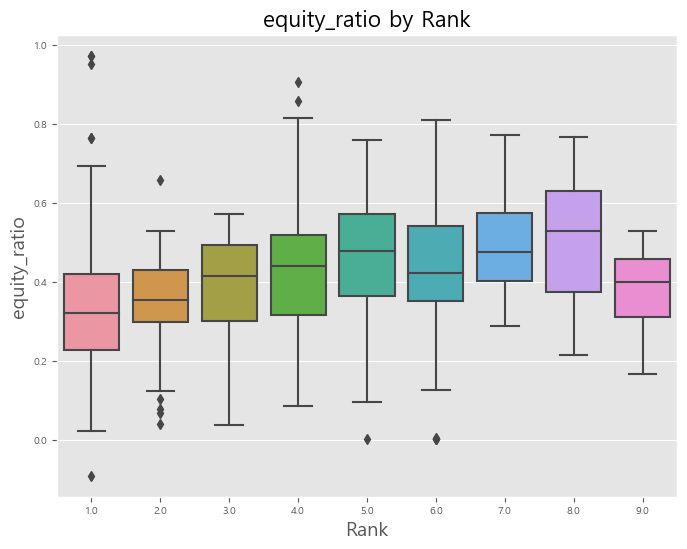

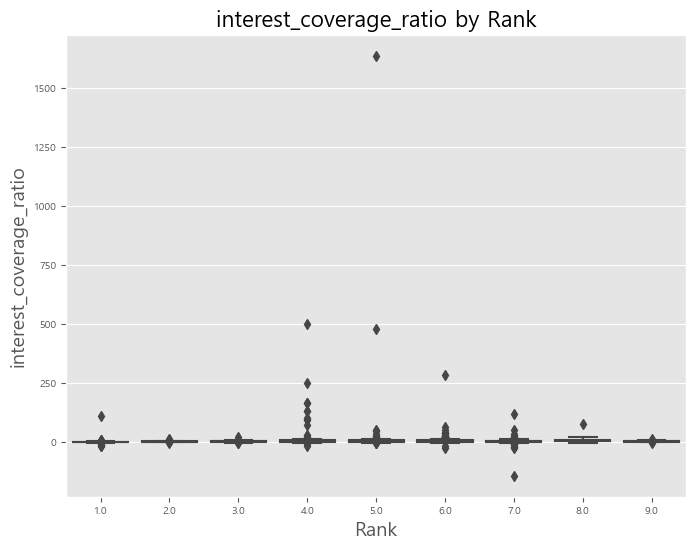

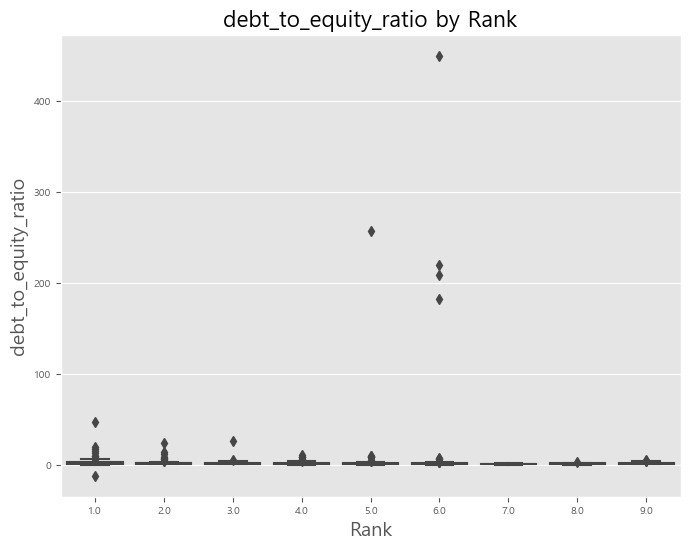

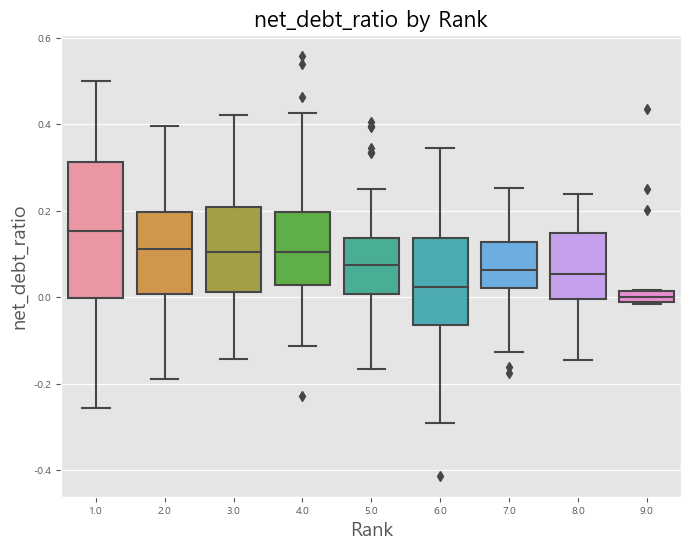

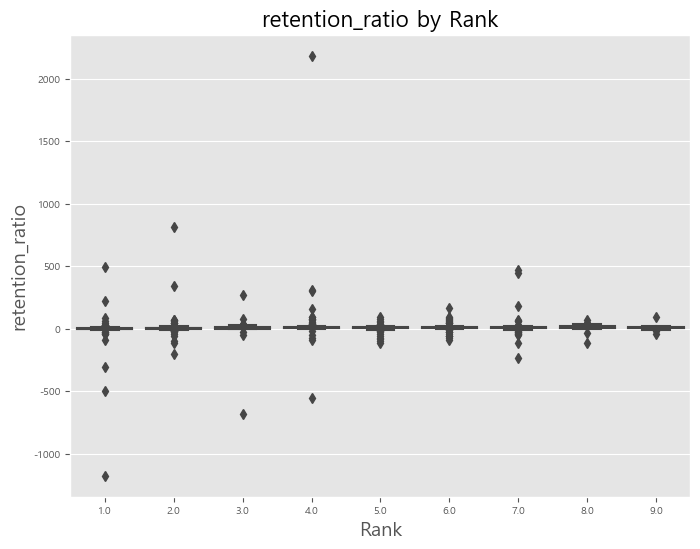

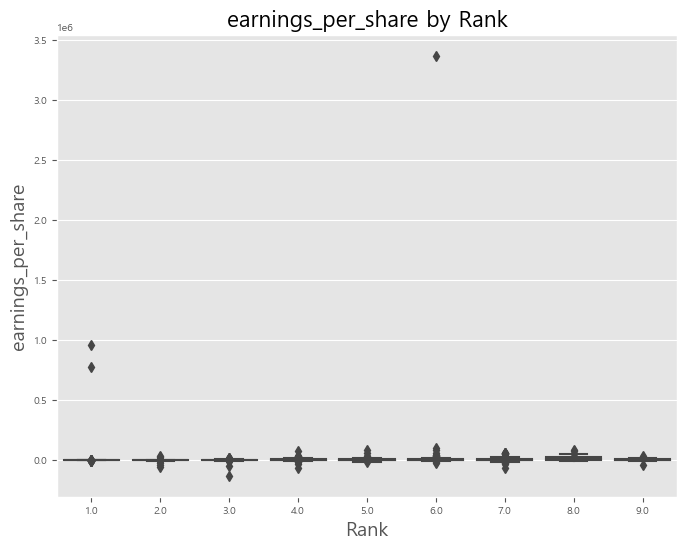

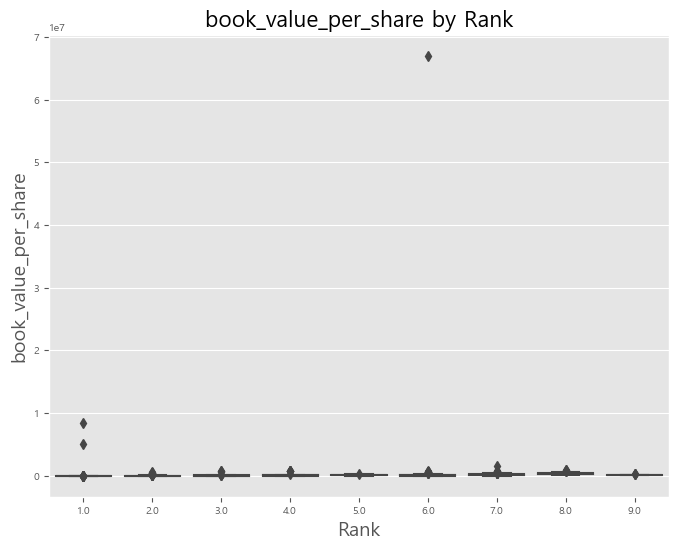

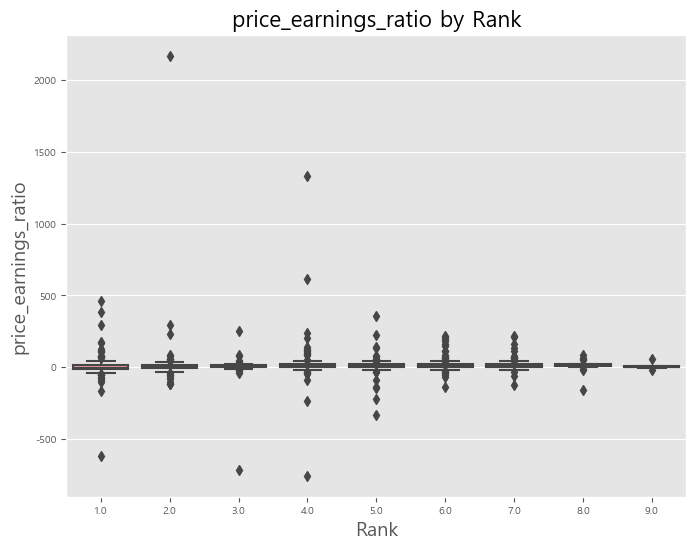

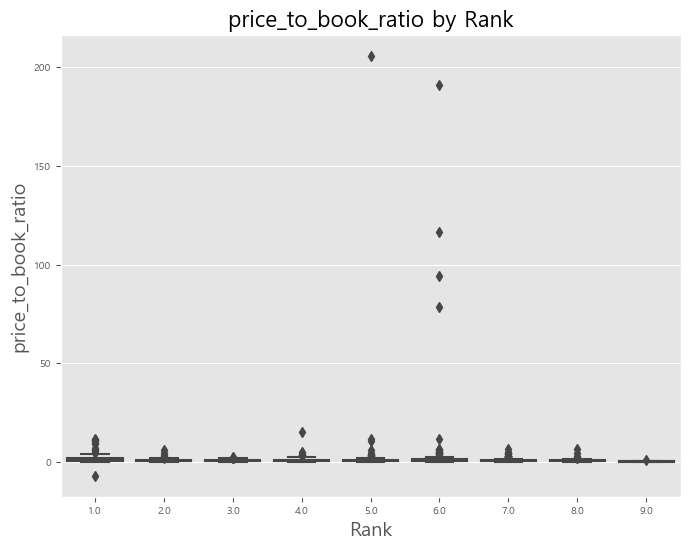

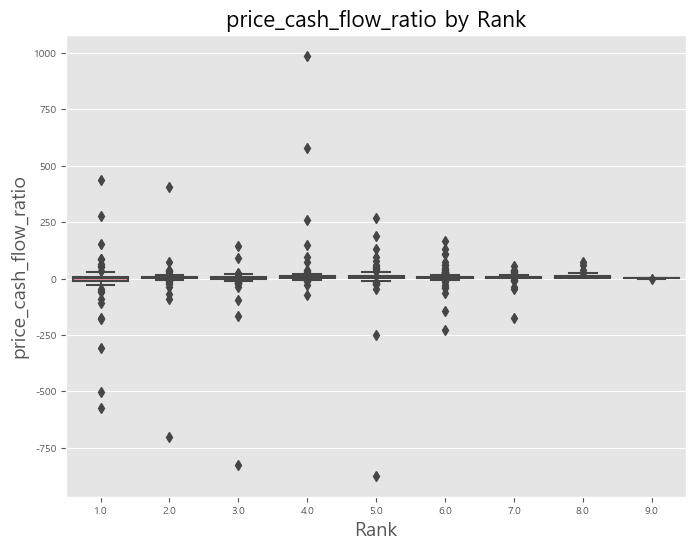

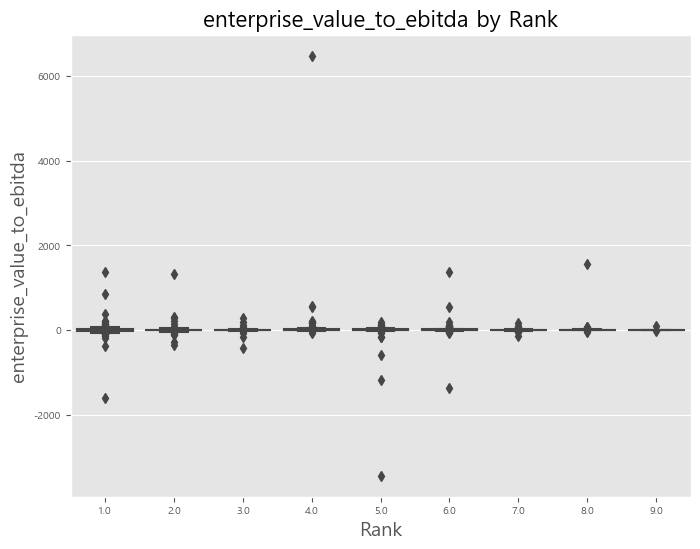

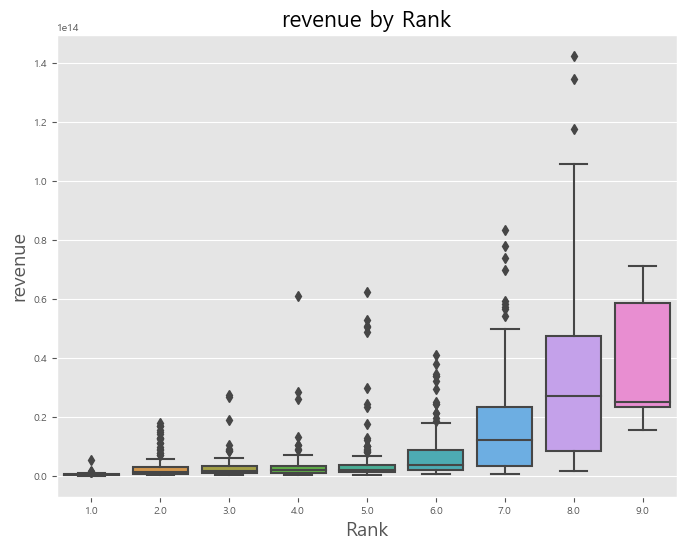

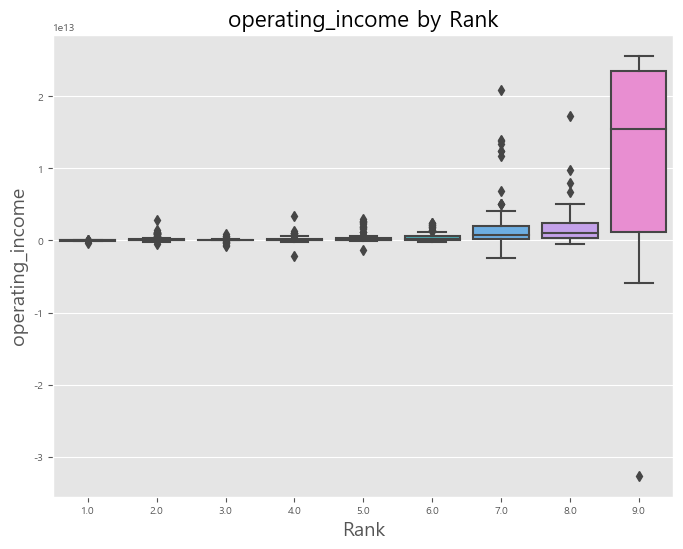

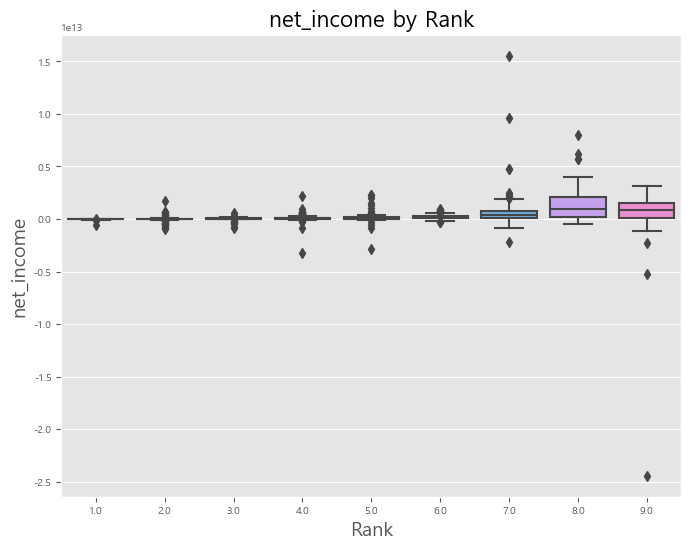

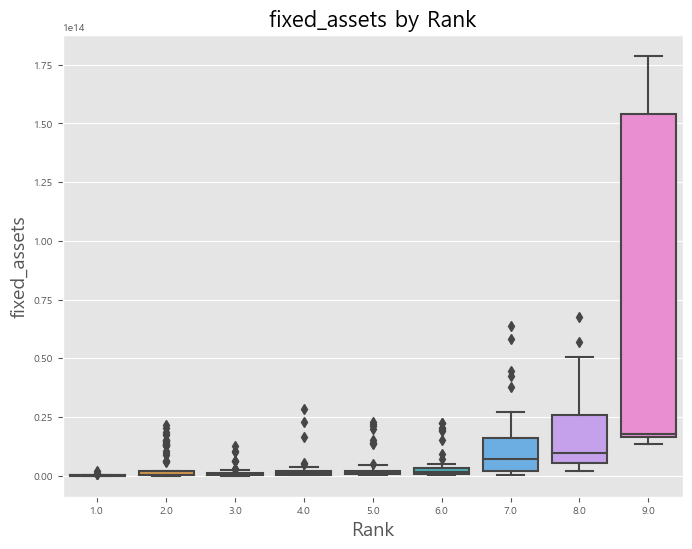

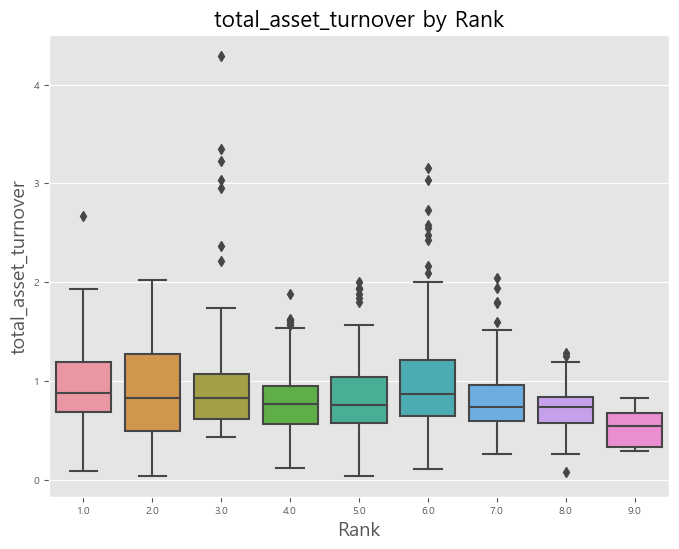

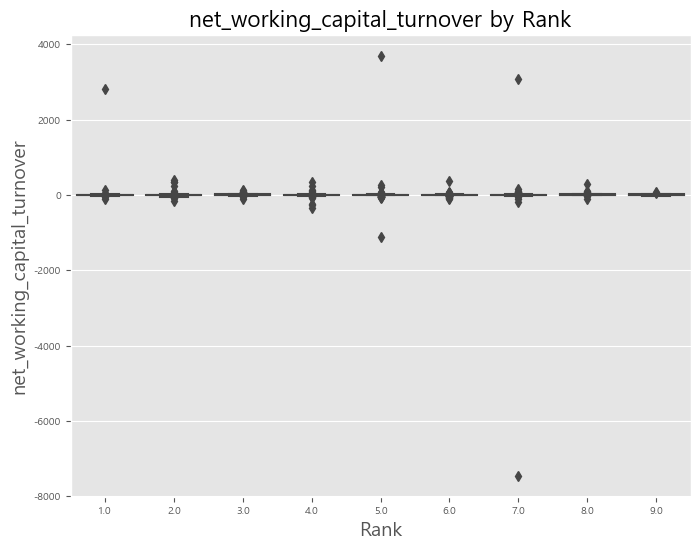

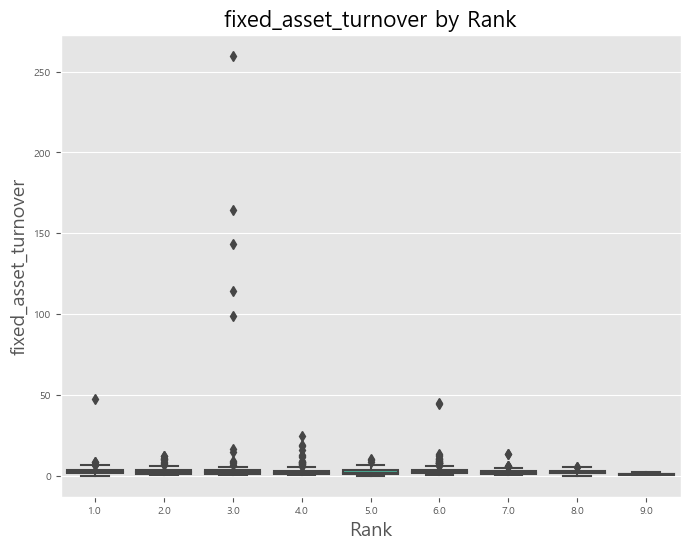

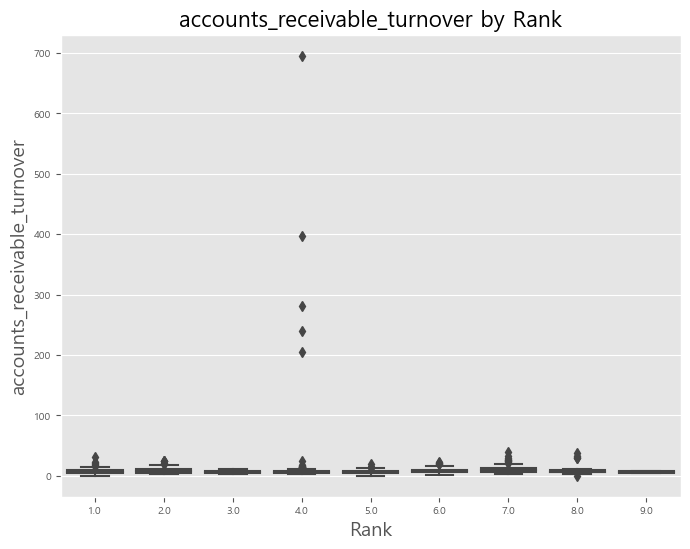

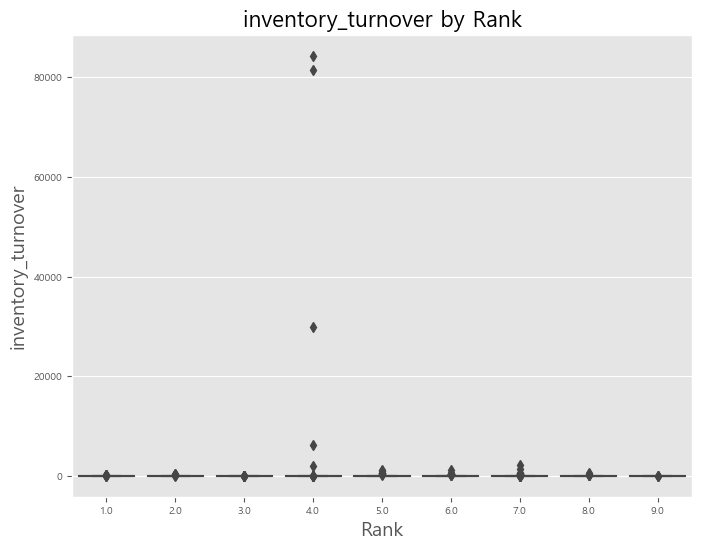

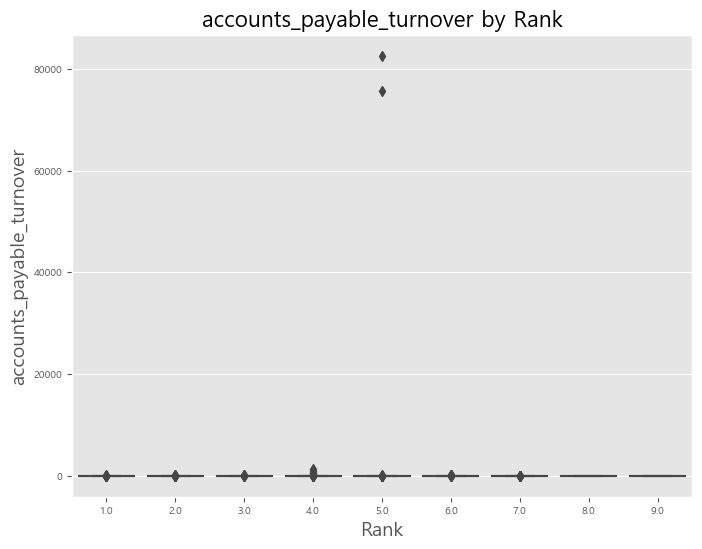

In [21]:
# rank에 따른 boxplot
# 데이터프레임에서 rank 열을 제외한 나머지 열들을 선택
columns_to_visualize = data_with_rank.columns[5:].drop('rank')

# 각 열에 대해 rank 값에 따른 분포를 boxplot으로 시각화
for column in columns_to_visualize:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='rank', y=column, data=data_with_rank)
    plt.title(f'{column} by Rank', fontsize=16)
    plt.xlabel('Rank', fontsize=14)
    plt.ylabel(column, fontsize=14)
    plt.show()

## 신용등급에 큰 영향을 미치는 변수는 무엇일까?

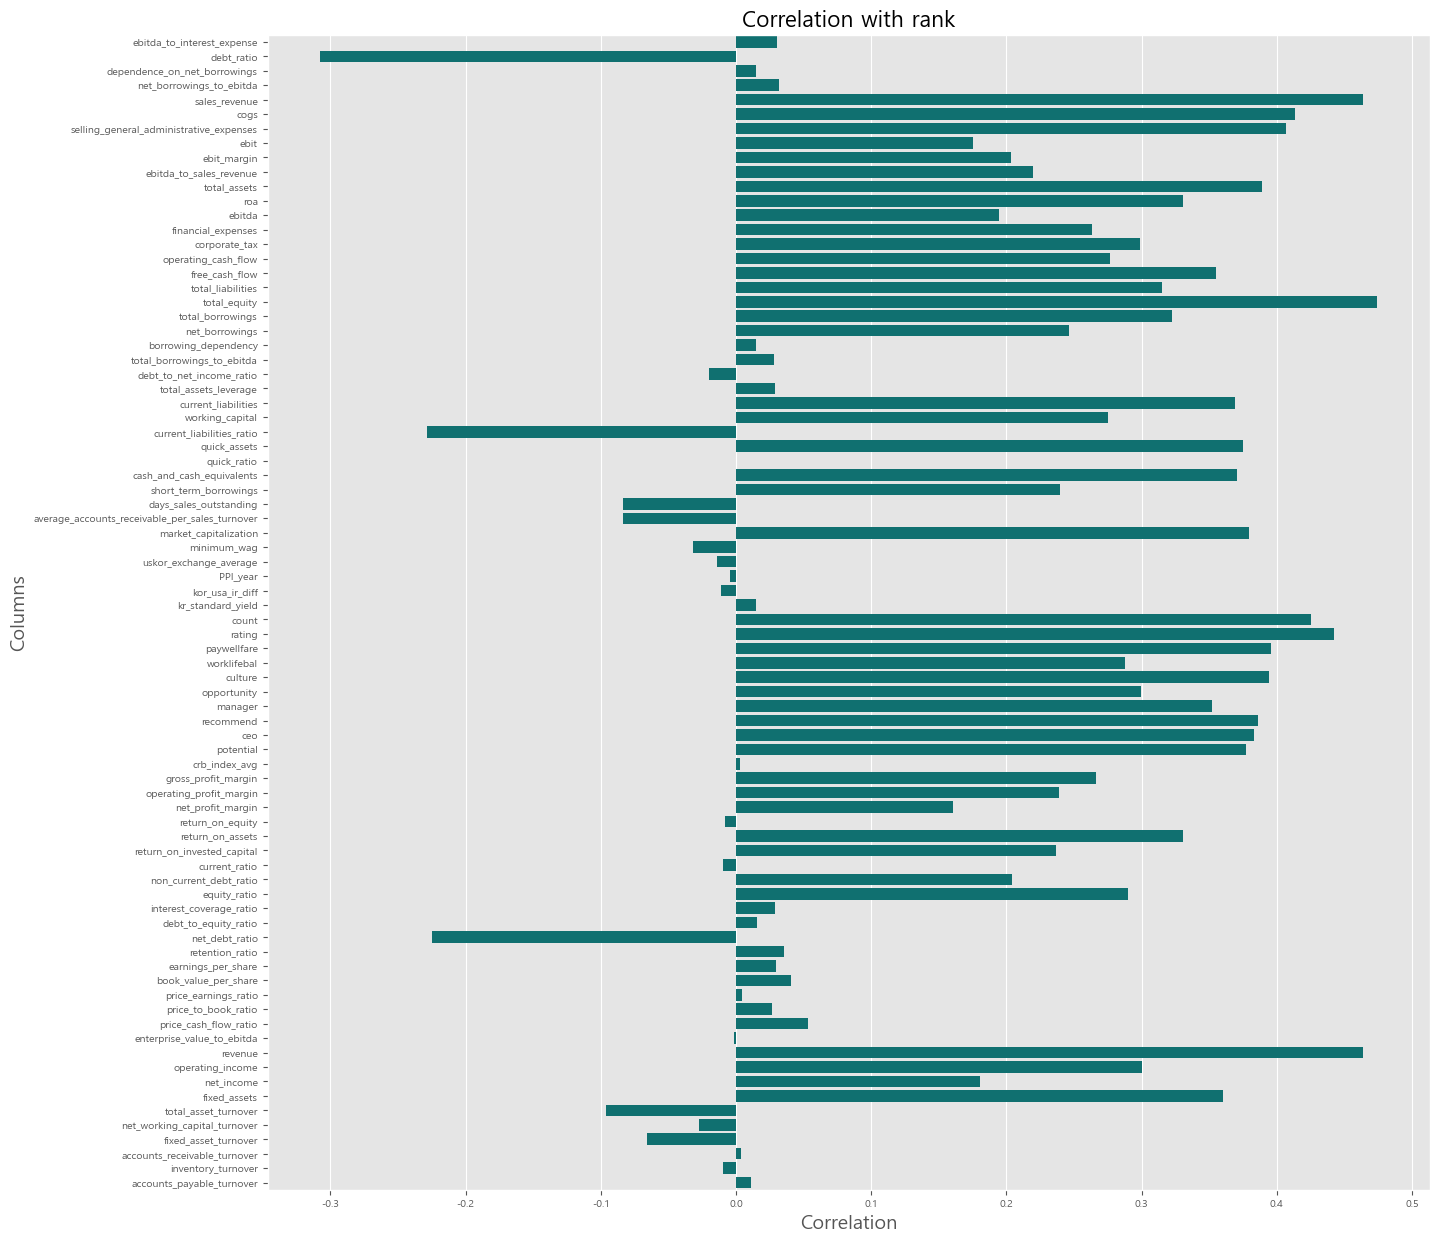

In [22]:
# rank 칼럼과 다른 칼럼들 간의 상관계수 계산
rank_correlation = data_with_rank.iloc[:, 5:].corrwith(data_with_rank['rank']).drop('rank')

# 상관계수를 시각화하여 가장 영향을 많이 주는 칼럼 파악
plt.figure(figsize=(15, 15))
sns.barplot(x=rank_correlation.values, y=rank_correlation.index, orient='h', color='Teal')
plt.title('Correlation with rank', fontsize=16)
plt.xlabel('Correlation', fontsize=14)
plt.ylabel('Columns', fontsize=14)
plt.show()

In [118]:
# 상관관계가 높은 상위 5개의 칼럼 추출
top_5_columns = rank_correlation.nlargest(5)
bot_5_columns = rank_correlation.nsmallest(5)

# 결과 출력
print("신용등급에 긍정적인 영향을 미치는 Top 5:")
for column, correlation in top_5_columns.items():
    print(f"{column} {np.round(correlation, 2)}")
    
print('')
print("신용등급에 부정적인 영향을 미치는 Top 5:")
for column, correlation in bot_5_columns.items():
    print(f"{column} {np.round(correlation, 2)}")

신용등급에 긍정적인 영향을 미치는 Top 5:
total_equity 0.47
sales_revenue 0.46
revenue 0.46
rating 0.44
count 0.43

신용등급에 부정적인 영향을 미치는 Top 5:
debt_ratio -0.31
current_liabilities_ratio -0.23
net_debt_ratio -0.22
total_asset_turnover -0.1
average_accounts_receivable_per_sales_turnover -0.08


주요 지표인 시가총액, 매출액, 신용등급에 공통적으로, 총 자본(total_equity) 이 각각 0.65, 0.9, 0.47 으로 크게 영향을 미치고 있다.

> 즉, 총 자본이 크다는 것은 기업이 안정적인 재무 상태를 갖고 있고 투자 가치가 높다는 것, 또한 매출액 증가에 기여할 수 있으며 기업이 자금 조달과 채무 상환에 충분한 여력을 갖고 있다는 것을 시사한다.